<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

###  Feature Engineering, Regression, and Regularization

---

The application of machine learning to home pricing is a burgeoning field. Companies like OpenDoor are taking on the historically insular and unscientific real estate sales market by applying data science to better predict trends, detect patterns, and ultimately undercut the competition. 

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The housing data available in this project has around 80 different variables cataloguing a wide variety of attributes for real estate properties. The target variable of interest is the sales price.

What has the most impact on the sales price of a house? Is just using square footage and building age sufficient, or are there other less obvious factors at play? You'll get to investigate what's important using EDA and regularized regression models, and practice model evaluation and cross-validation.

---

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Load the `housing.csv` dataset

---

The csv is located in the `DSI-SF-4/datasets/housing_regression` folder in your repo. 

**There is a file describing the columns in the dataset in the `data_description.txt` file in the same folder that contains the information on what the variables represent.**


In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
house = pd.read_csv('../../../x/DSI-SF-4/datasets/housing_regression/housing.csv')

In [3]:
texted = open('../../../x/DSI-SF-4/datasets/housing_regression/data_description.txt')
txts = texted.write

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Examine the `SalePrice` variable

---

### 2.1 Plot the distribution of the `SalesPrice` variable and describe it with pandas

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

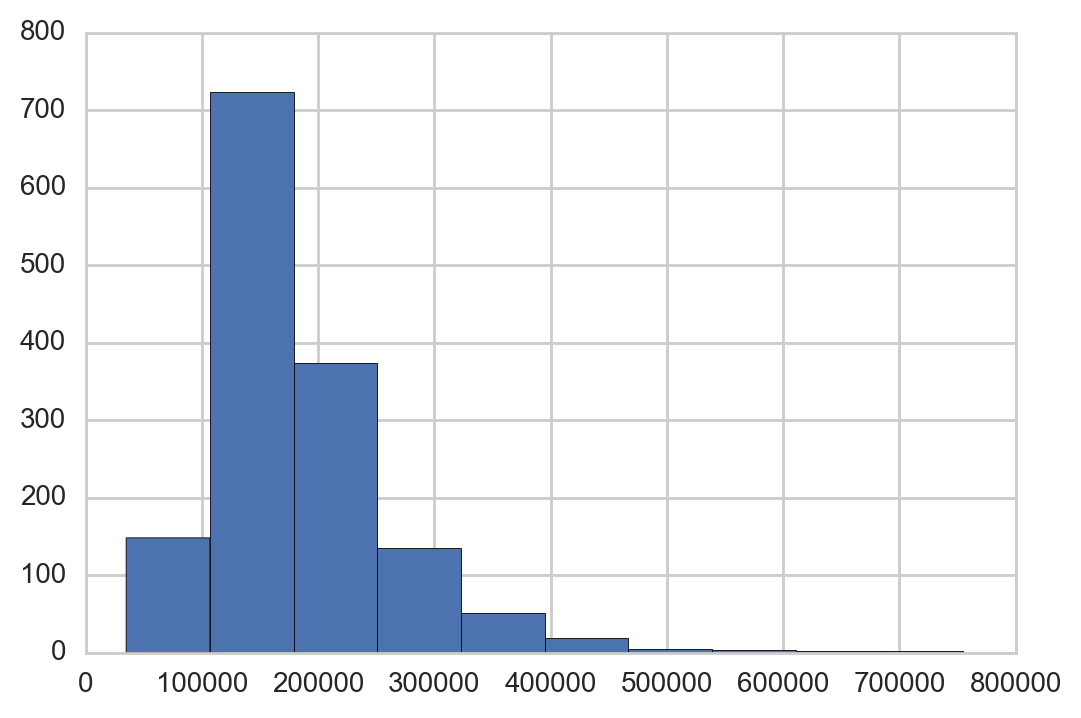

In [4]:
house.SalePrice.hist()
house.SalePrice.describe()

### 2.2 Create a transformed version of the `SalesPrice` variable that makes it more normally distributed

Two common transformations to deal with long tails are taking the square root and taking the log of a variable. 

Plot the transformed variable.

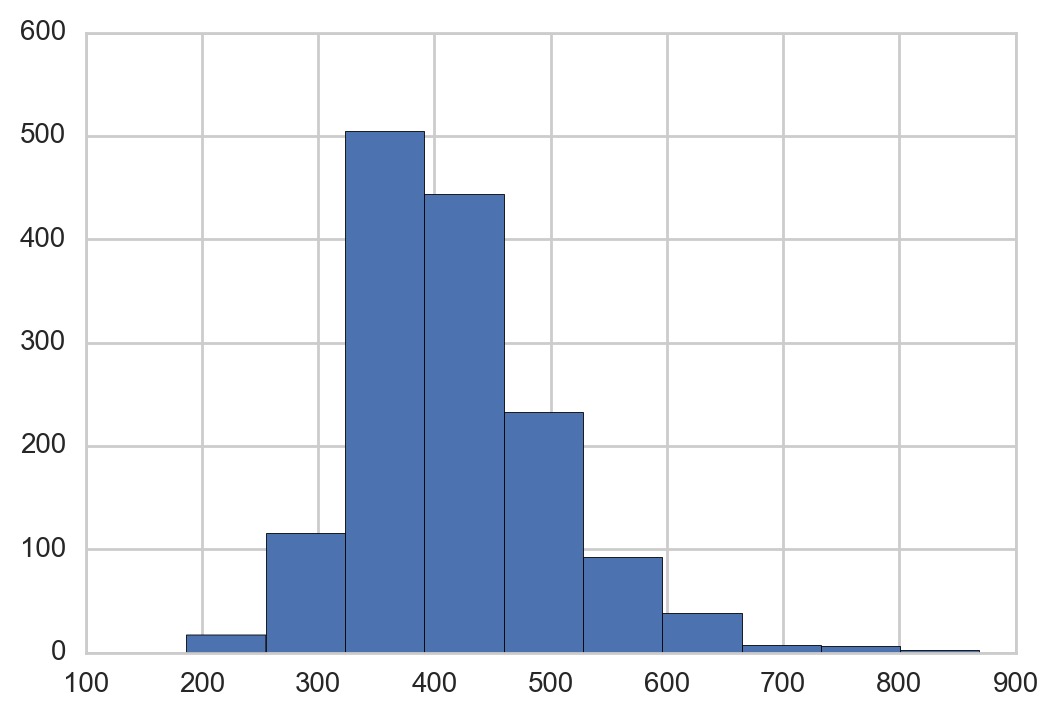

In [5]:
house['sqrtSalePrice'] = np.sqrt(house.SalePrice)
house['logSalePrice'] = np.log(house.SalePrice)

house.sqrtSalePrice.hist() #Transformed SalePrice(Sqrt)

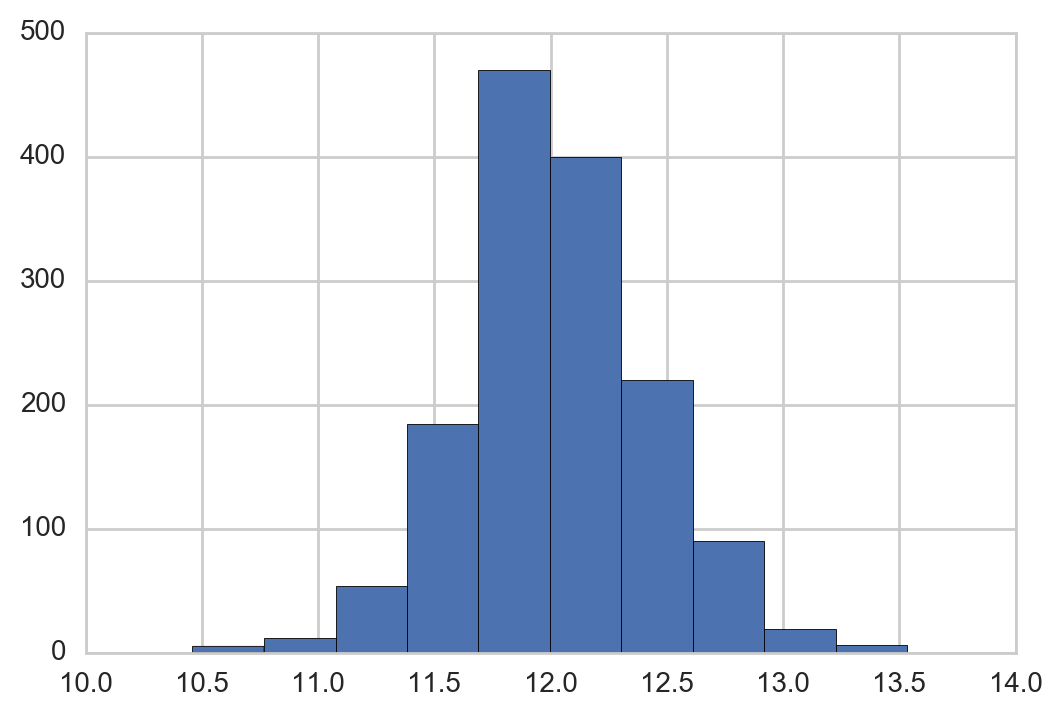

In [6]:
house.logSalePrice.hist() #Transformed Saleprice (log)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Correlations with sale price

---

### 3.1 Correlate the age of a house when sold with the sale price

How is the correlation different when using the original and transformed sale price?


In [7]:
print house[['YearBuilt','SalePrice']].corr()
print house[['YearBuilt','logSalePrice']].corr()
print house[['YearBuilt','sqrtSalePrice']].corr()
#The correlation effectively increases when we take the sqrt of the SalePrice series, and again increases (though not
#as much), when we take the log of the SalePrice series.

           YearBuilt  SalePrice
YearBuilt   1.000000   0.522897
SalePrice   0.522897   1.000000
              YearBuilt  logSalePrice
YearBuilt       1.00000       0.58657
logSalePrice    0.58657       1.00000
               YearBuilt  sqrtSalePrice
YearBuilt       1.000000       0.564284
sqrtSalePrice   0.564284       1.000000


### 3.2 Plot the age of the house at sale against the sale price variables

How does it differ between the original and transformed variables? What do the charts indicate about the relationship between the variables?

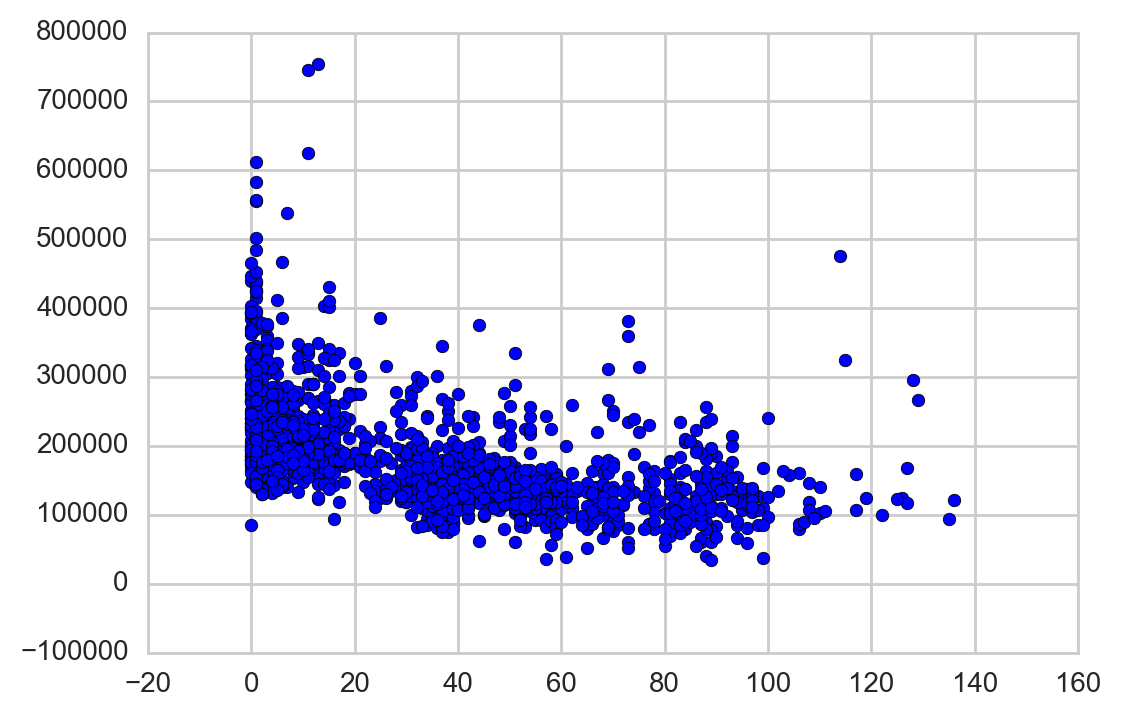

In [8]:
#The original sale price variable appears to give the tightest spread of results, showing only a modest decline in
# sale price as the age at sale increases. However when we observe the logSalePrice plot, we can visibly note a more
#significant downward trend after 20, 40, and even 60 years. This trend is made even more clear when looking at the
#sqrtSalePrice plot, where we can clearly see drop-offs at the 20, 40, and 60 year marks. But we can also note that
#after the 60 year mark, there appears to be no further significant correlative degredation to Sale Price due to age
#of the house at sale.
house['AgeAtSale'] = house.YrSold - house.YearBuilt

sns.plt.scatter(house.AgeAtSale, house.SalePrice)

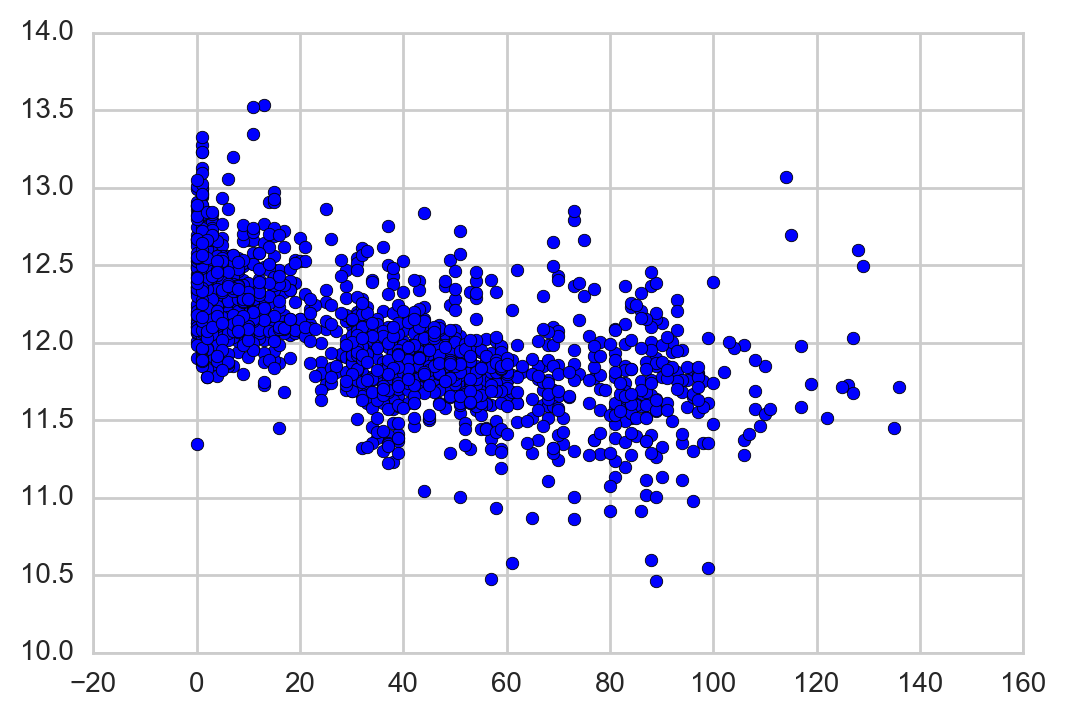

In [9]:
sns.plt.scatter(house.AgeAtSale, house.logSalePrice)

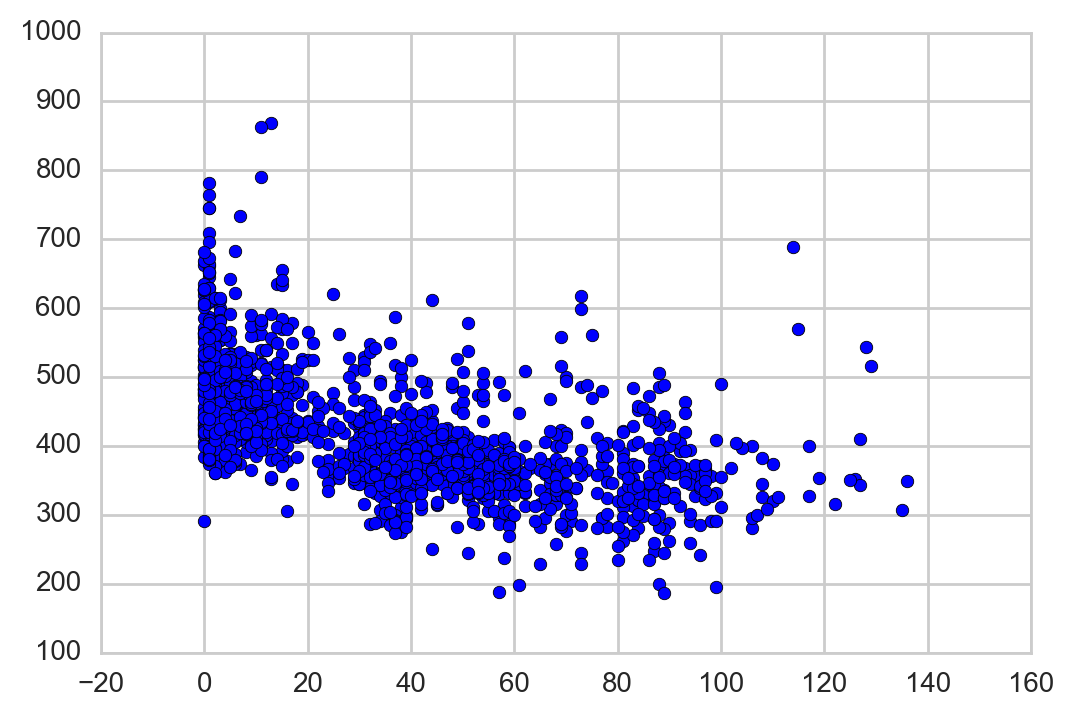

In [10]:
sns.plt.scatter(house.AgeAtSale, house.sqrtSalePrice)

### 3.3 Visually compare price to total livable square feet, `GrLivArea`

What is the relationship, if any?

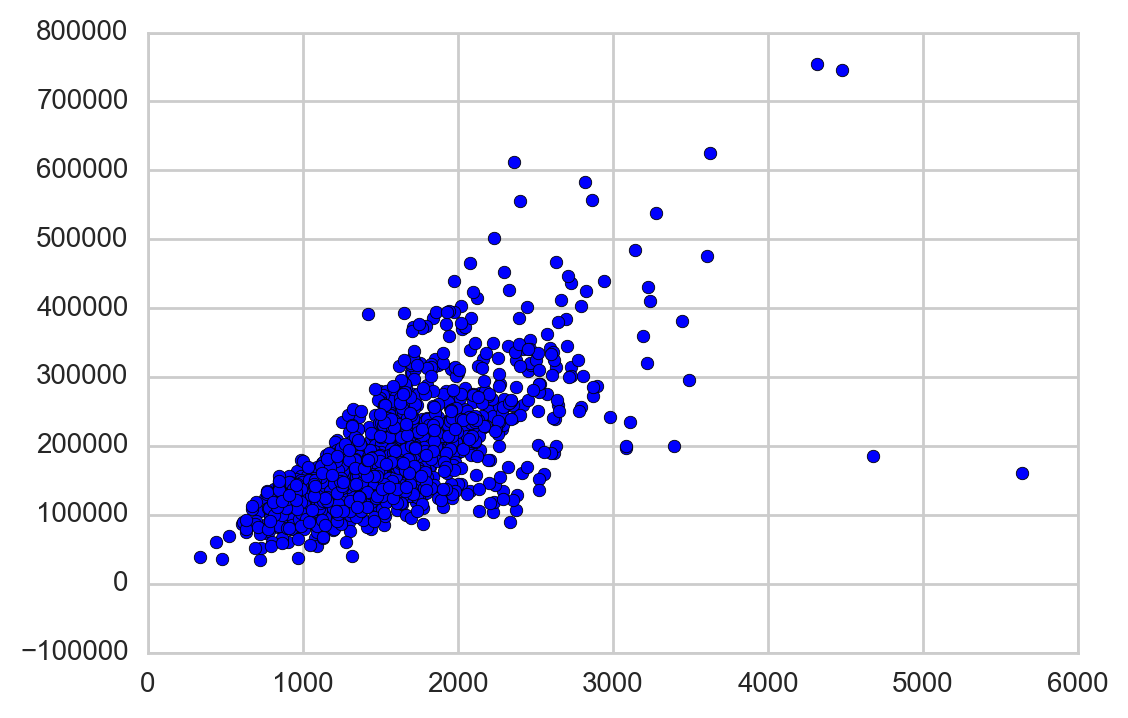

In [11]:
#There is a significant linear relationship between total livable square feet and SalePrice, particularly when we
#look at the sqrtSalePrice plot.

sns.plt.scatter(house.GrLivArea, house.SalePrice)

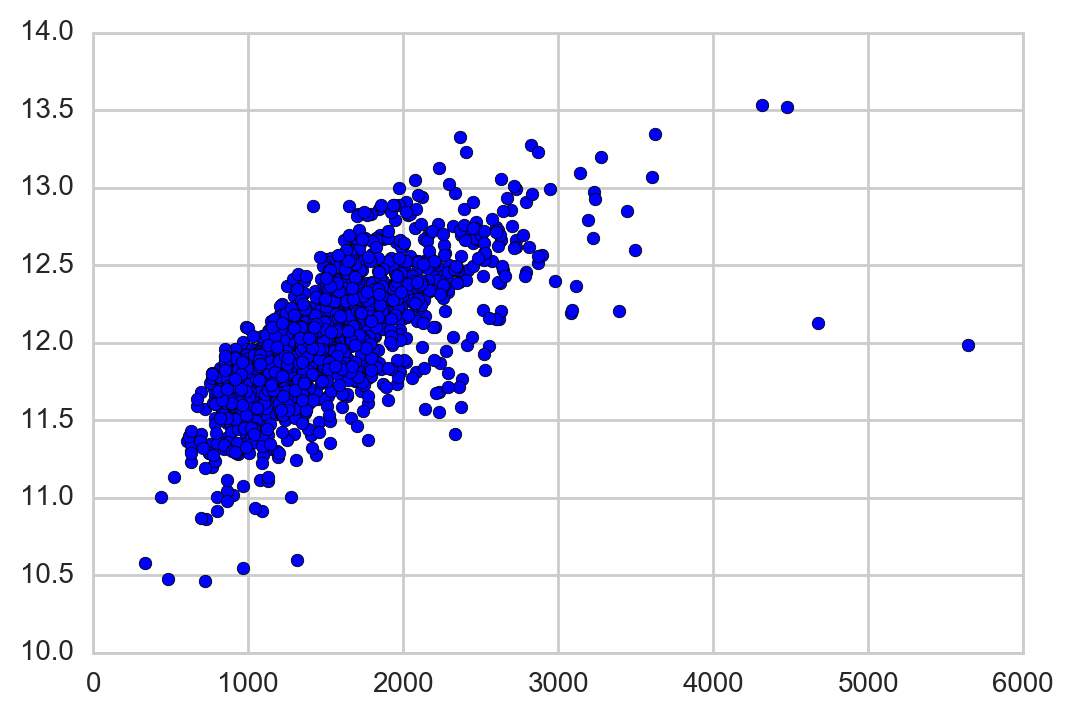

In [12]:
sns.plt.scatter(house.GrLivArea, house.logSalePrice)

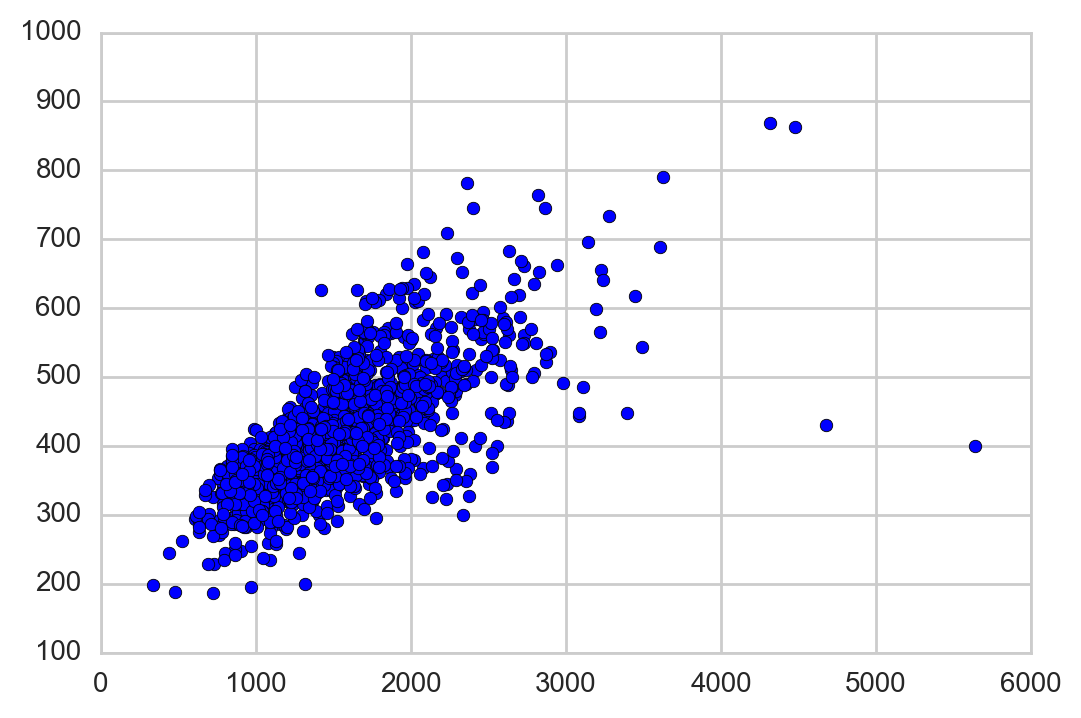

In [13]:
sns.plt.scatter(house.GrLivArea, house.sqrtSalePrice)

### 3.4 Plot and describe the relationship between two continuous variables of your choice in the data

Why did you choose those variables? What is the relationship that the chart sbows, if any?

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


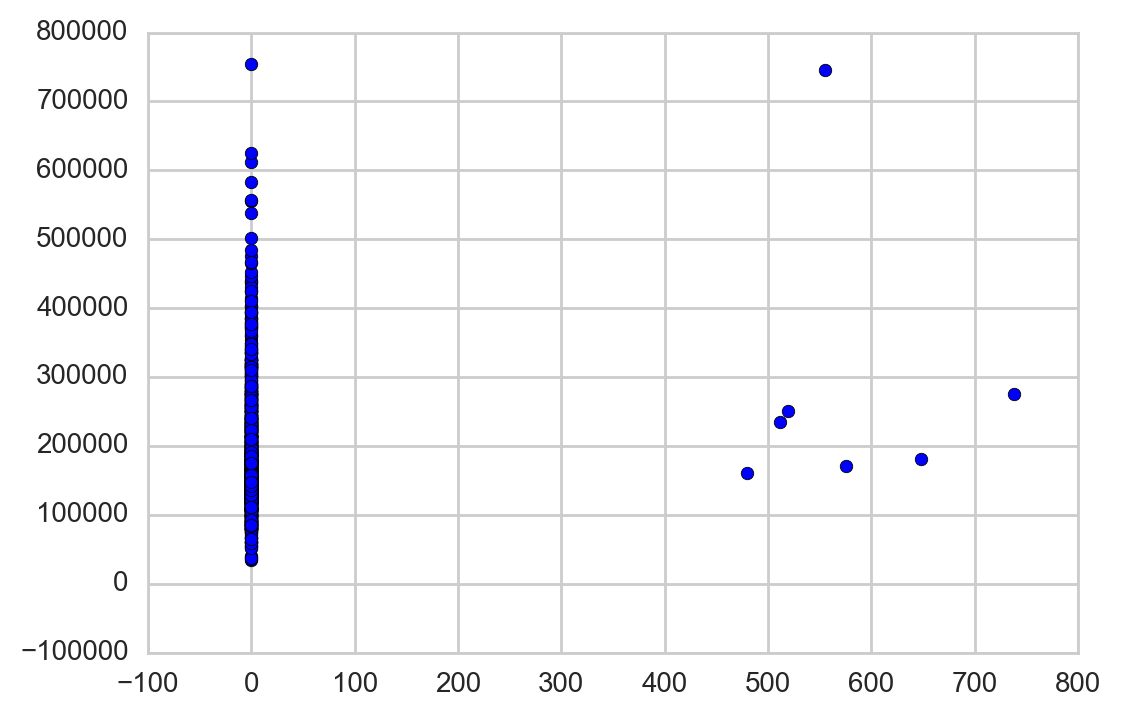

In [14]:
house.columns.unique()
house.describe().T

#I chose pool area and GrLivArea because I suspected that having a pool on a property would correlate not just
#with price, but with the size of the house on the property. I wanted to test this assumption. Unfortunately, the
#number of properties with pools was extremely limited, and even with the available data, no observable trend was
#found. So I instead went back to my prior assumption, and measured SalePrice against GrLivArea. But again, I found
#that the relationship between pool area and SalePrice was tenuous at best. My datapoints primarily fell within
#$100,000 to $300,000 SalePrice

# sns.plt.scatter(house.PoolArea, house.GrLivArea)
sns.plt.scatter(house.PoolArea, house.SalePrice)

    <img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Data transformation and quality assessment

---

**Note: from this point onward, you can use your transformed price variable or the original price variable. Up to you. It will change the interpretation of the coefficients in your model.**

### 4.1 Restrict the data 

Only keep houses that are residential (remove the commercial code buildings).

In [15]:
house.columns.unique()
Res_houses = house[house['MSZoning'] != 'C (all)']
Res_houses.head()
# cl_house = 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,sqrtSalePrice,logSalePrice,AgeAtSale
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2008,WD,Normal,208500,456.618002,12.247694,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,5,2007,WD,Normal,181500,426.028168,12.109011,31
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,9,2008,WD,Normal,223500,472.757866,12.317167,7
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,2,2006,WD,Abnorml,140000,374.165739,11.849398,91
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,12,2008,WD,Normal,250000,500.000000,12.429216,8


### 4.2 Handle null values in the dataset

Many of the variables contain null values. In many of these cases the null value is actually representative of a category that is a level of a categorical variable.

Eliminate the null values from your dataset, explaining your rationale for each variable. You have options for null values:

- Replace the null values (impute).
- Drop the observation.
- Drop the variable. 

In [16]:
Res_houses.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageFinish      79
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [17]:
Res_houses.Alley.value_counts()

Grvl    50
Pave    39
Name: Alley, dtype: int64

In [18]:
Res_houses.LotFrontage.fillna(0, inplace=True) #Replace NaN observations w/ 0, since quant variable
Res_houses.Alley.fillna('None', inplace=True) # Drop NaN observations since 1361, and replace w/ categorical
Res_houses.MasVnrType.fillna('No masonry', inplace=True) #Drop NaN observations, since only 8 in all
Res_houses.MasVnrArea.fillna(0, inplace=True) #Drop NaN observations, since only 8 in all
Res_houses.BsmtQual.fillna('No basement', inplace=True) #Replace NaN observations, since only 37 in all
Res_houses.BsmtCond.fillna('No basement', inplace=True) #Replace NaN observations, since only 37 in all
Res_houses.BsmtExposure.fillna('No basement', inplace=True) #Replace NaN observations, since only 38 in all
Res_houses.BsmtFinType1.fillna('No basement', inplace=True) #Replace NaN observations, since only 38 in all
Res_houses.BsmtFinType2.fillna('No basement', inplace=True) #Replace NaN observations, since only 38 in all
Res_houses.Electrical.fillna('None', inplace=True) #Replace NaN since just 1 in all
Res_houses.FireplaceQu.fillna('No pool', inplace=True) #Drop NaN observations, since only 681 in all, replace w/ cat.
Res_houses.GarageYrBlt.fillna('No garage', inplace=True) #Replace NaN observations? 79 in all
# After careful reconsideration, I have decided to DROP THIS MOTHAF*CKA, b/c I can't imagine that the year the
# garage built was terribly important. Otherwise, I'd be feeding in a string into a series full of integers, and I'd
# rather not do that.
Res_houses.drop('GarageYrBlt', axis=1, inplace=True)
Res_houses.GarageType.fillna('No garage', inplace=True) #Replace NaN observations? 79 in all
Res_houses.GarageFinish.fillna('No garage', inplace=True) #Replace NaN observations? 79 in all
Res_houses.GarageQual.fillna('No garage', inplace=True) #Replace NaN observations? 79 in all
Res_houses.GarageCond.fillna('No garage', inplace=True) #Replace NaN observations? 79 in all
Res_houses.PoolQC.fillna('No pool', inplace=True) #Drop variable since 1443 NaN, replace with categorical variable
Res_houses.Fence.fillna('None', inplace=True) #Drop variable since 1172 NaN, replace with categorical variable
Res_houses.MiscFeature.fillna('None', inplace=True) #Drop variable since 1398 NaN, replace with categorical variable

Res_houses.head()

//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,sqrtSalePrice,logSalePrice,AgeAtSale
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,None,0,2,2008,WD,Normal,208500,456.618002,12.247694,5
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,None,0,5,2007,WD,Normal,181500,426.028168,12.109011,31
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,None,0,9,2008,WD,Normal,223500,472.757866,12.317167,7
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,None,0,2,2006,WD,Abnorml,140000,374.165739,11.849398,91
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,None,0,12,2008,WD,Normal,250000,500.000000,12.429216,8


### 4.3 Remove any variables you think are not viable to use as predictors of price.

This can be a subjective process. A common criterion is to remove variables that have little to no variance. This would be, for example, a  variable where nearly all observations were in a single category or had a single value. 

For each variable you remove (if any), explain your rationale for why.

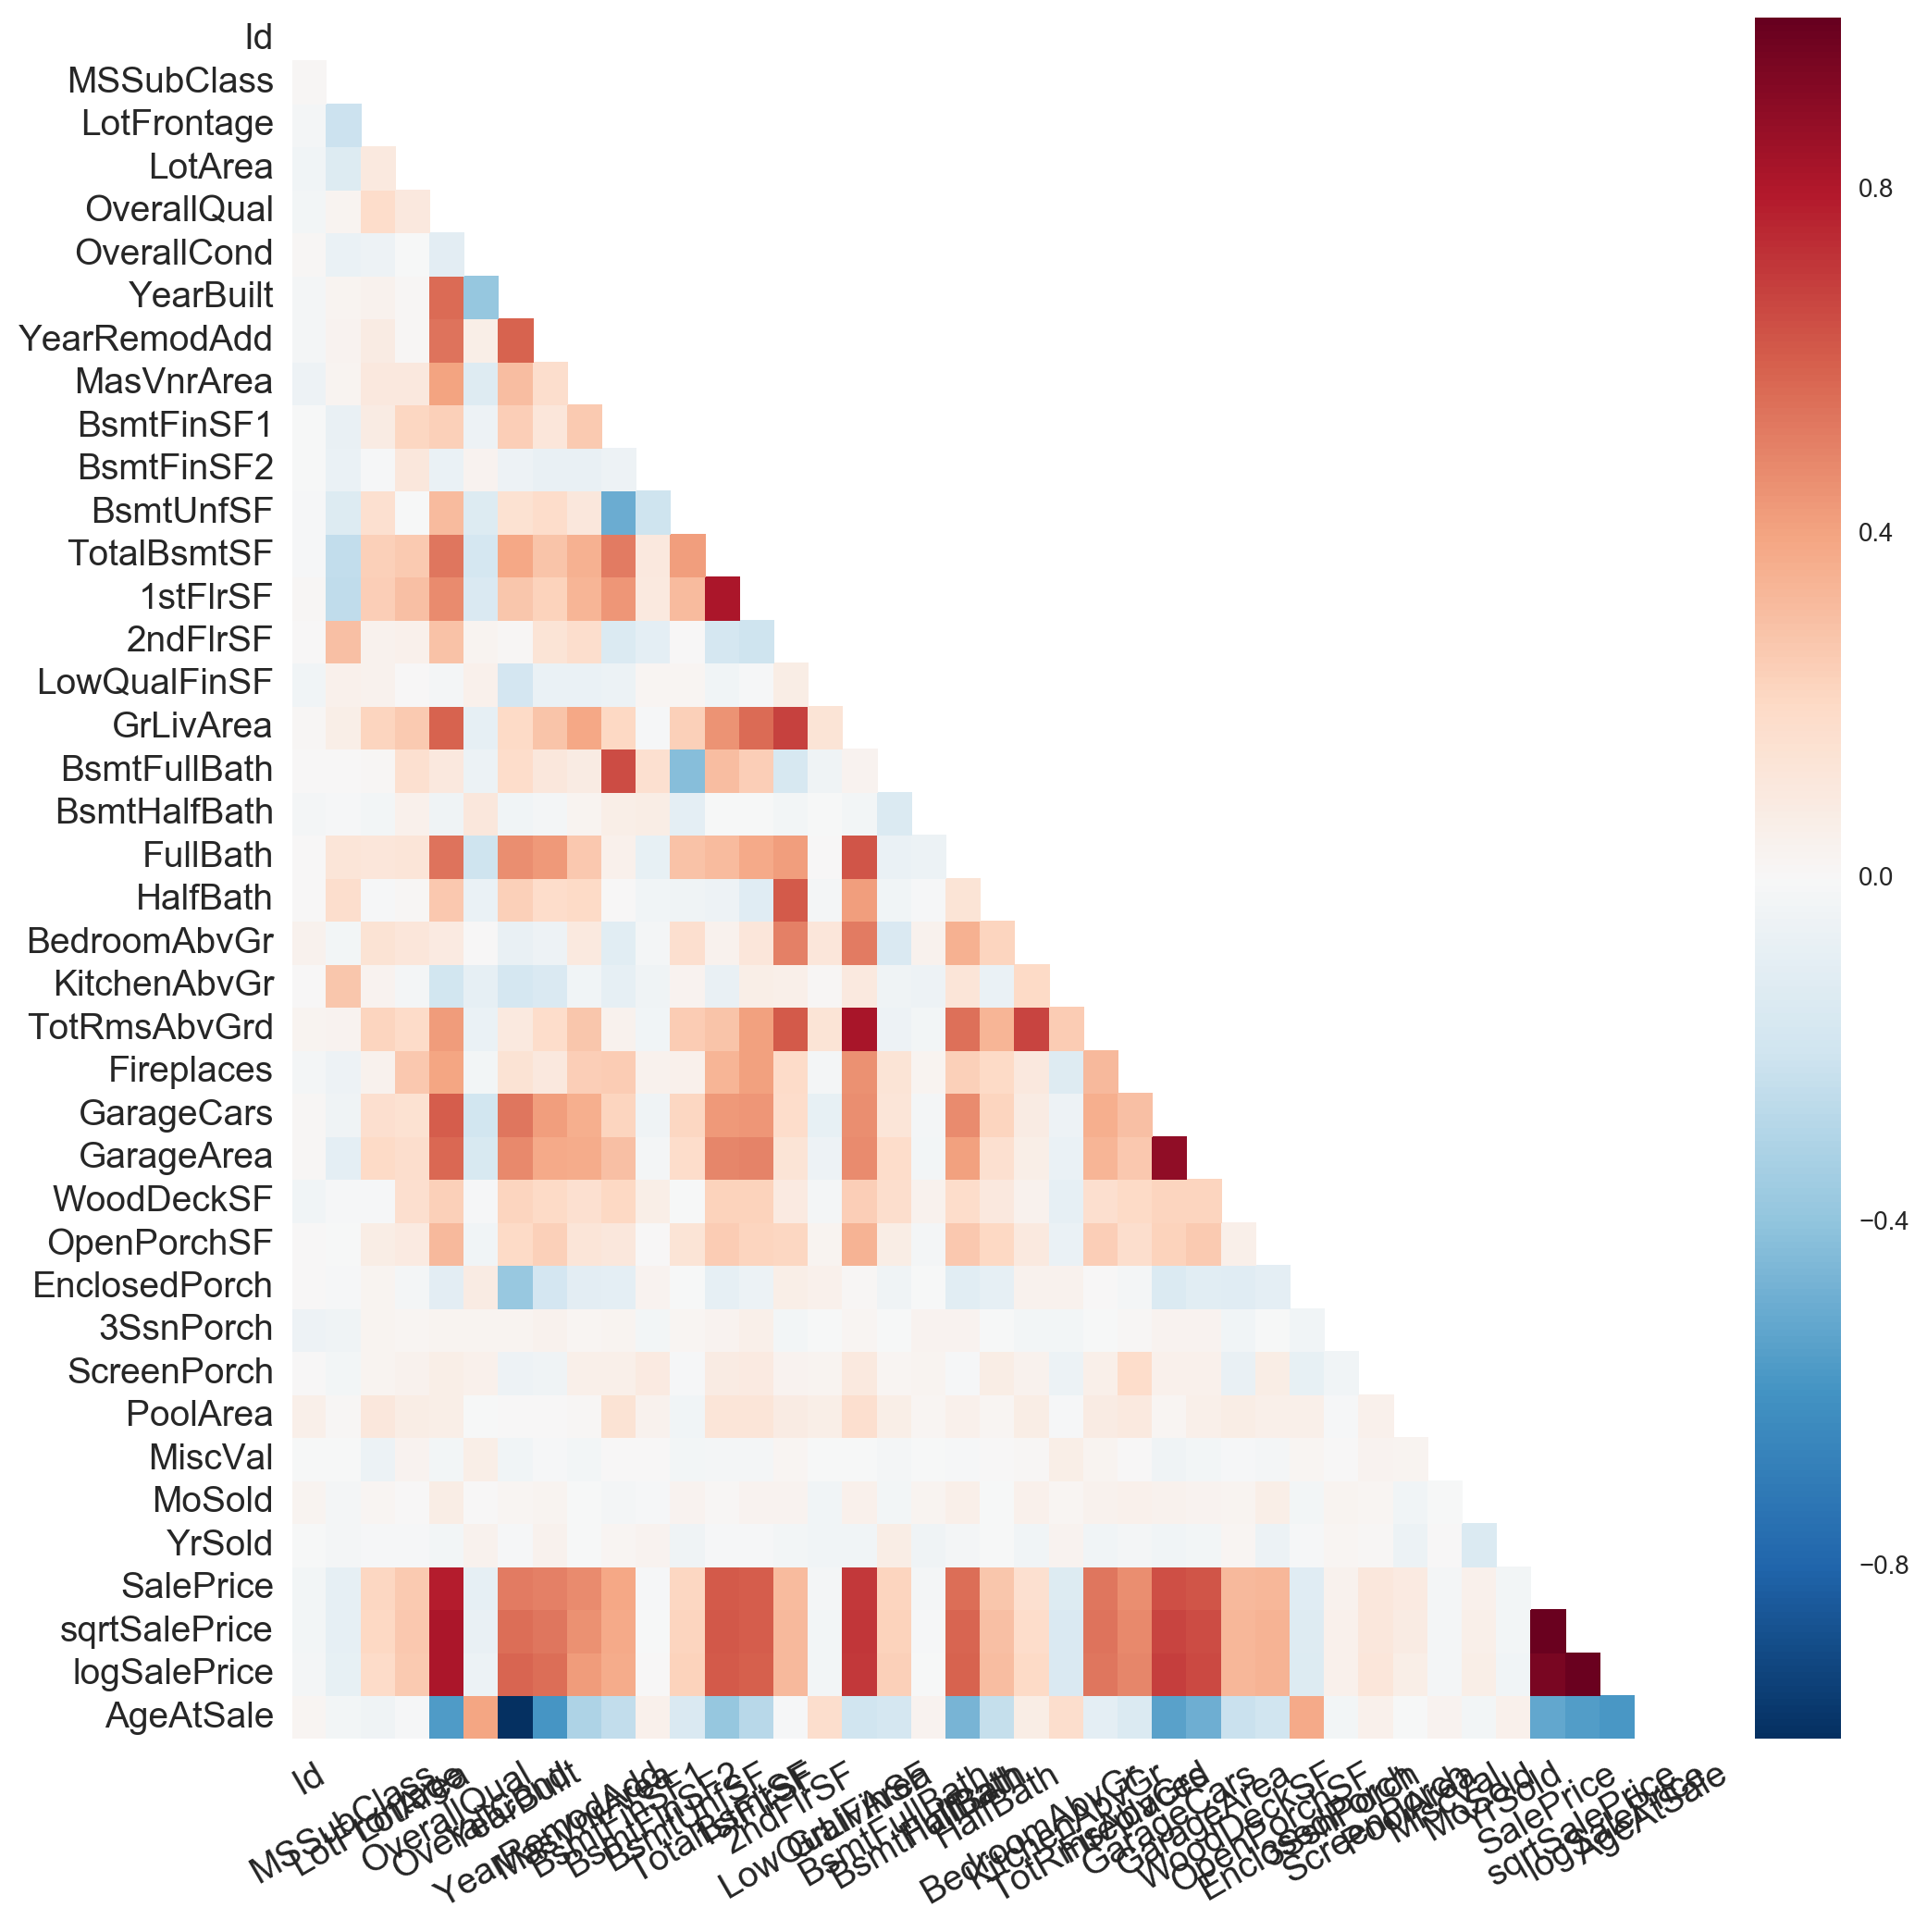

In [19]:
#Check to make sure that the variables are not too correlated w/ one another, otherwise drop one of the two vars
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=False)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(Res_houses)

# Eliminated ID b/c it's an arbitrary number
# Eliminated MSSubClass because it has minimal noticable correlation across most other variables, except for ones
#           accounting for number of floors or other misc. figures that don't share intrinsic effects w/ other vars.
# Eliminated BsmtHalfBath, BsmtFinSF2, LowQualFinSF, KitchenAbvGr, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold,
# YrSold b/c none of these show much viable correlative info so...LESS BLOW DIS BISH UP

In [20]:
# purified_boston =  Res_houses.drop(['Id','MSSubClass','BsmtHalfBath','BsmtFinSF2','LowQualFinSF','KitchenAbvGr','3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','MoSold','YrSold'], axis=1, inplace=True) 

In [21]:
Res_houses.columns.unique()

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Wood

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Plot a correlation matrix between the continuous variables

---

**Some columns in the DataFrame are numeric type, but that doesn't necessarily mean that they are continuous. Sometimes numeric values are used to represent the levels of a categorical variable.**

To plot a correlation matrix, it is popular to represent the correlation values using hue with a "heatmap". Look up how to plot a heatmap of a correlation matrix in python and show it below. Make sure that the variable labels are clear on the axes.

Describe anything interesting or notable you observe from the correlation matrix.

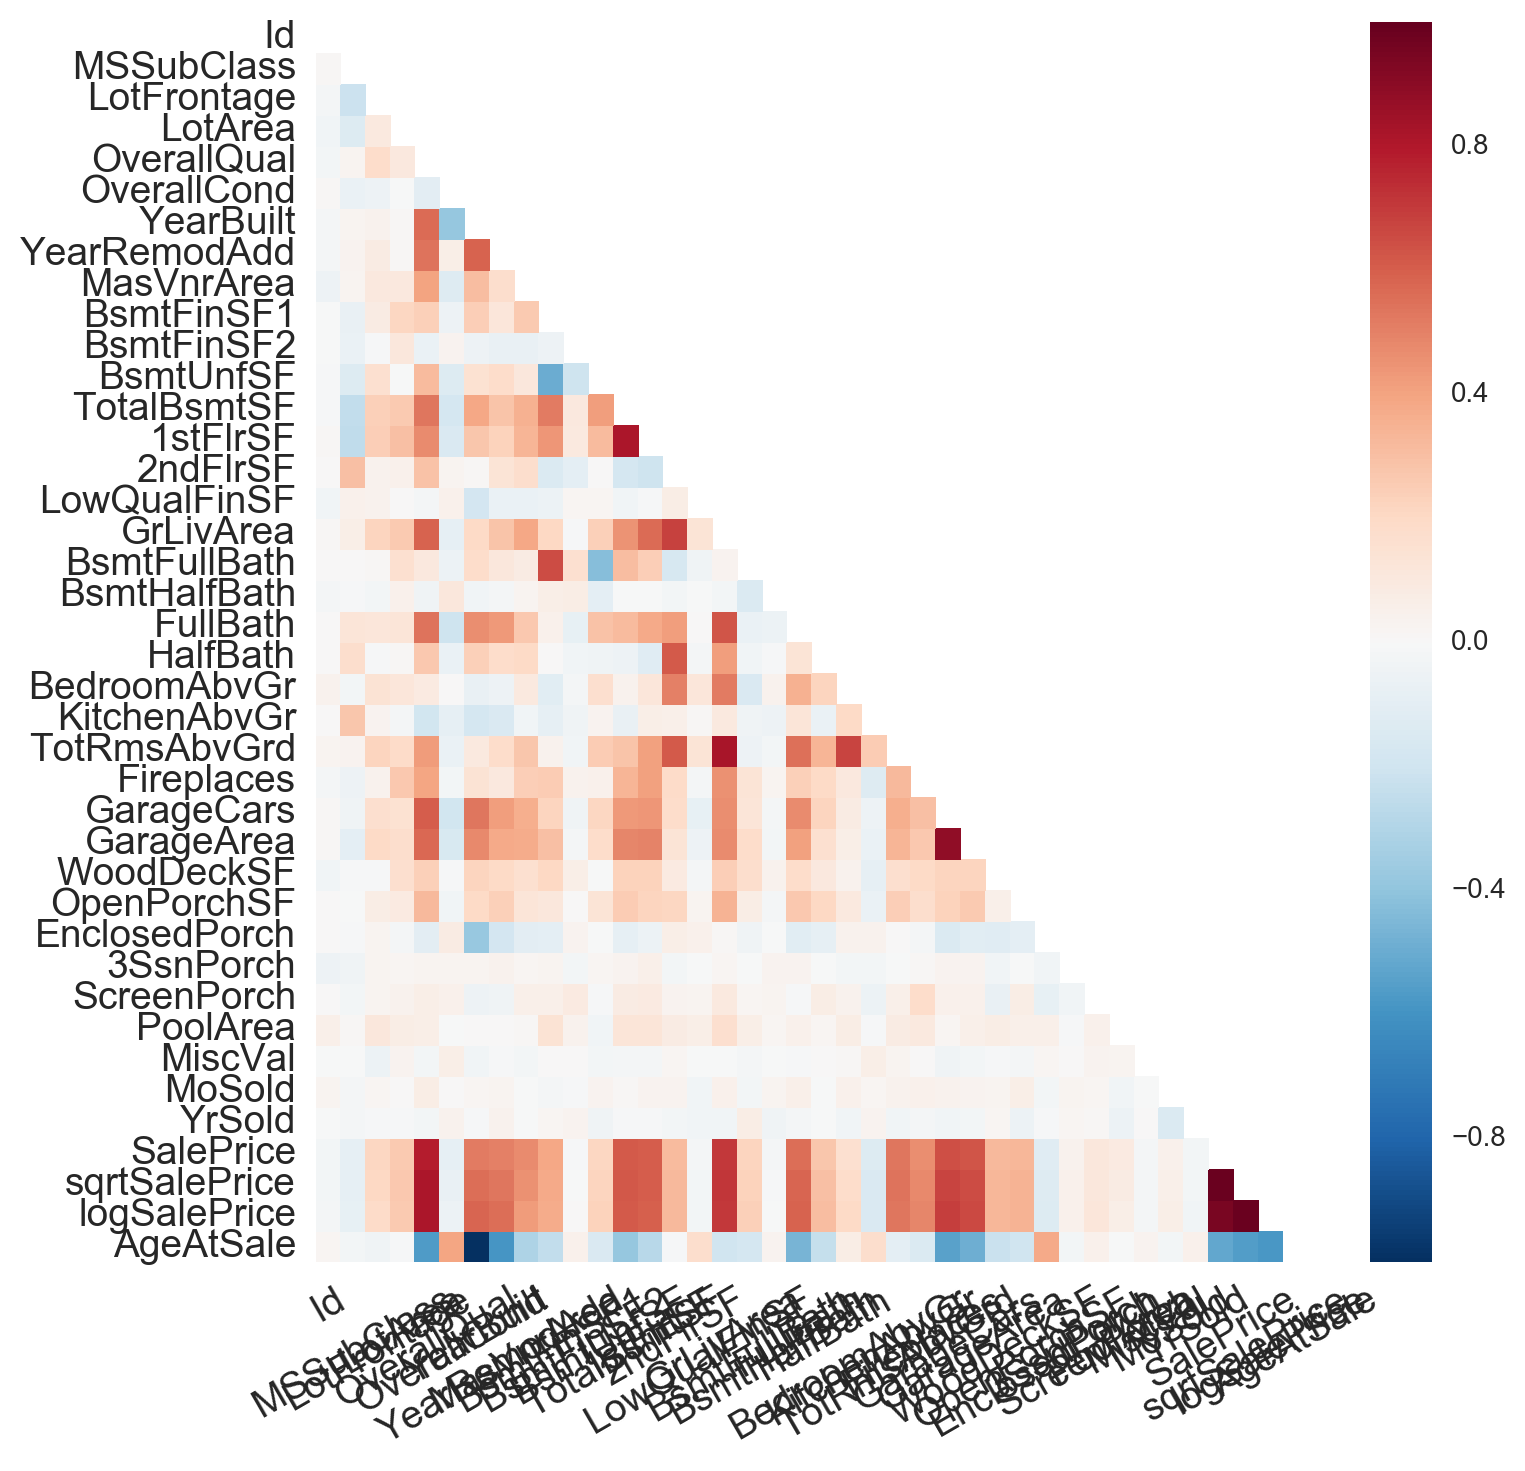

In [22]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(8,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=False)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(Res_houses)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Make boxplots of categorical variables against the sale price

---

You don't have to plot all of them unless you want to. Make at least 8 boxplots looking at the distribution of sale price across levels of categorical variables in your dataset. This can be whichever categorical variables interest you the most.

Write up a few findings on the relationship between sales price and the categorical variables you chose to plot. Anything surprising?

In [23]:
Res_houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,sqrtSalePrice,logSalePrice,AgeAtSale
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,None,0,2,2008,WD,Normal,208500,456.618002,12.247694,5
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,None,0,5,2007,WD,Normal,181500,426.028168,12.109011,31
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,None,0,9,2008,WD,Normal,223500,472.757866,12.317167,7
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,None,0,2,2006,WD,Abnorml,140000,374.165739,11.849398,91
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,None,0,12,2008,WD,Normal,250000,500.000000,12.429216,8


In [24]:
Res_houses.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

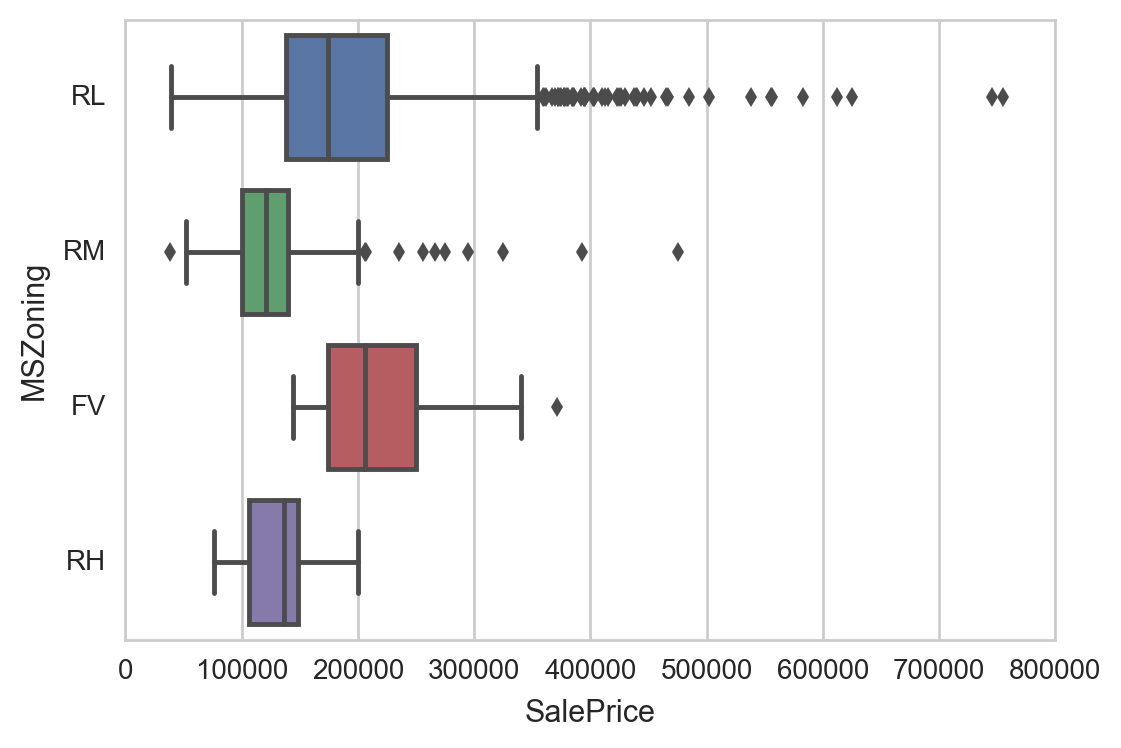

In [25]:
sns.boxplot(x = Res_houses.SalePrice, y=Res_houses.MSZoning) #Residential Low Density predominates, while 
# Floating Village Residential (though only 4% of data)

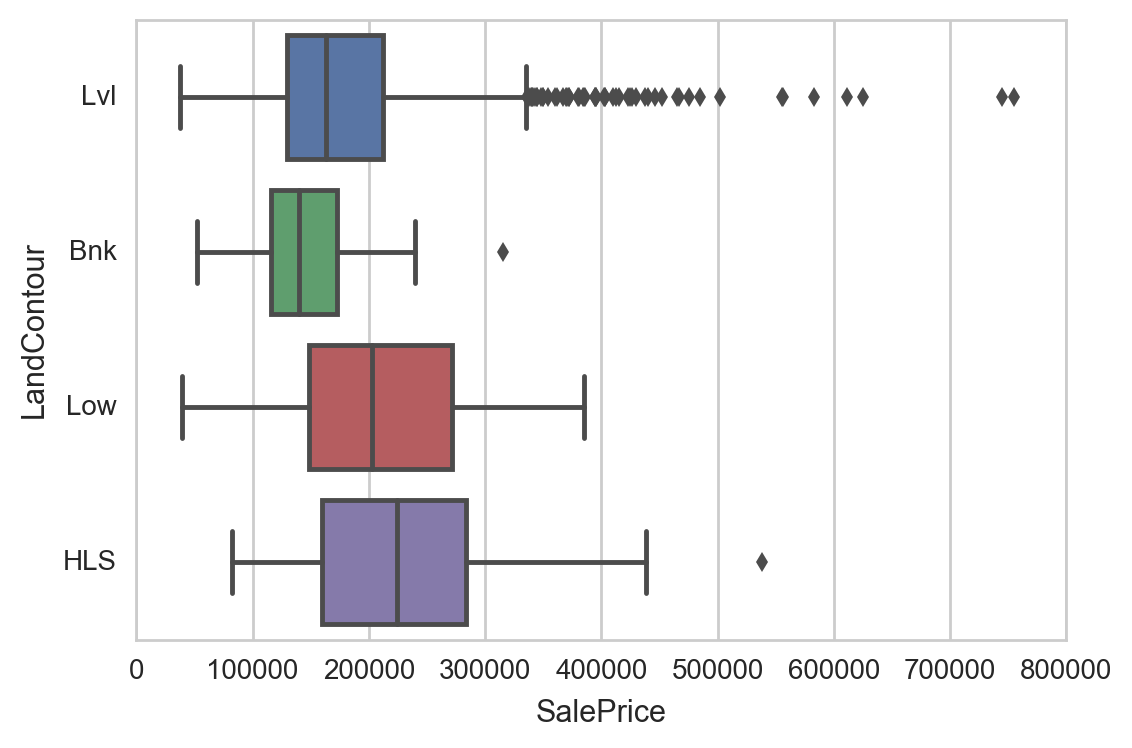

In [26]:
sns.boxplot(x=Res_houses.SalePrice, y= Res_houses.LandContour) #For some reason, Hillside properties do well (HLS)

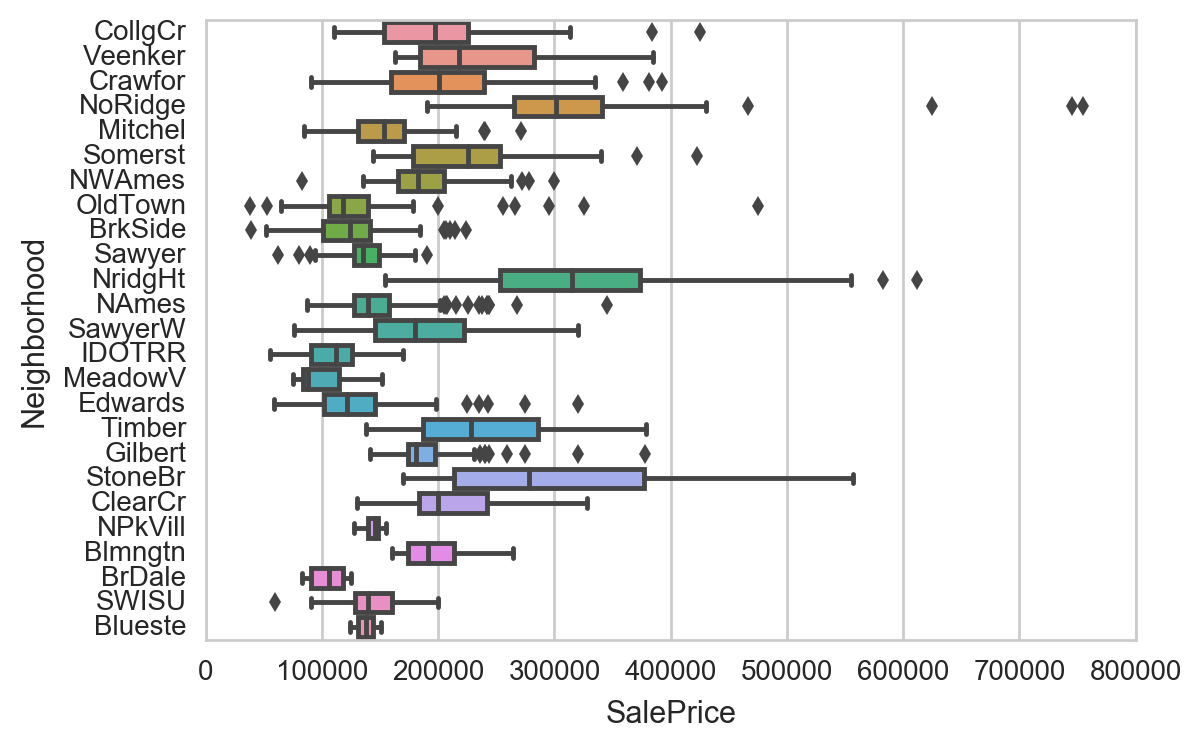

In [27]:
sns.boxplot(x=Res_houses.SalePrice, y= Res_houses.Neighborhood) #Northridge Heights is pretty fancy, and Stone Brook
# too, though Northridge actually has a higher median than the latter (with a shorter distribution)

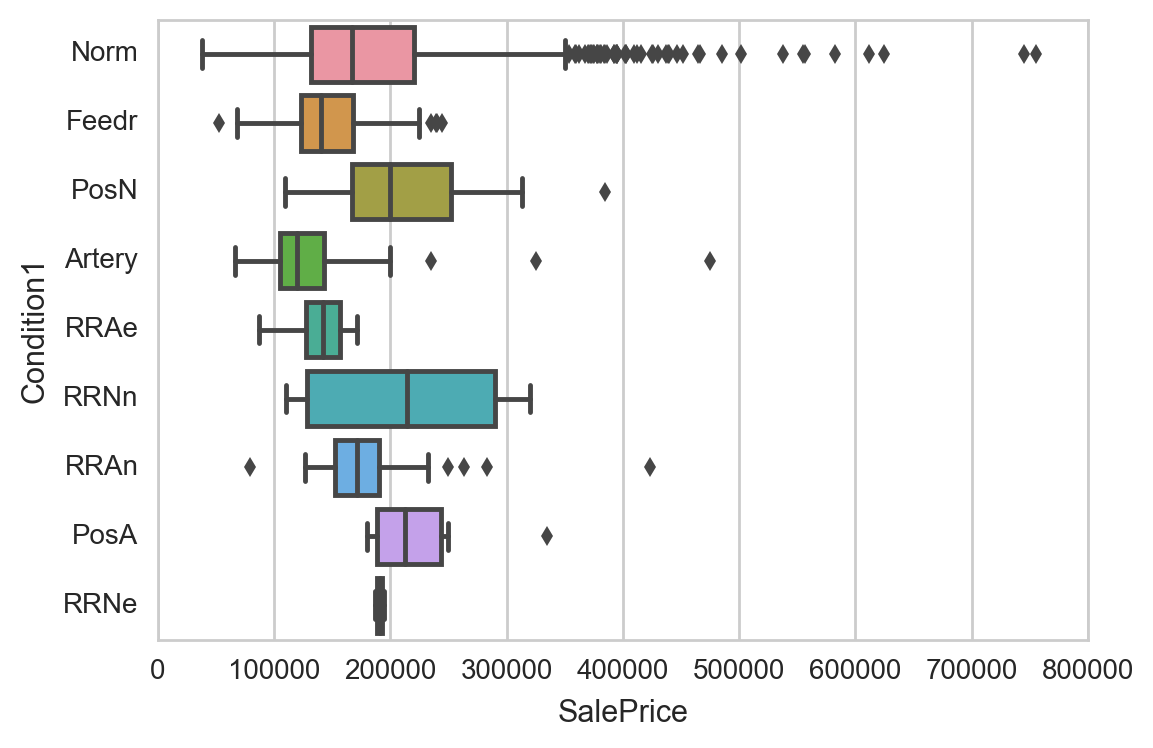

In [28]:
sns.boxplot(x=Res_houses.SalePrice, y= Res_houses.Condition1) #weird correlation to North/South railroads! (RRNn)

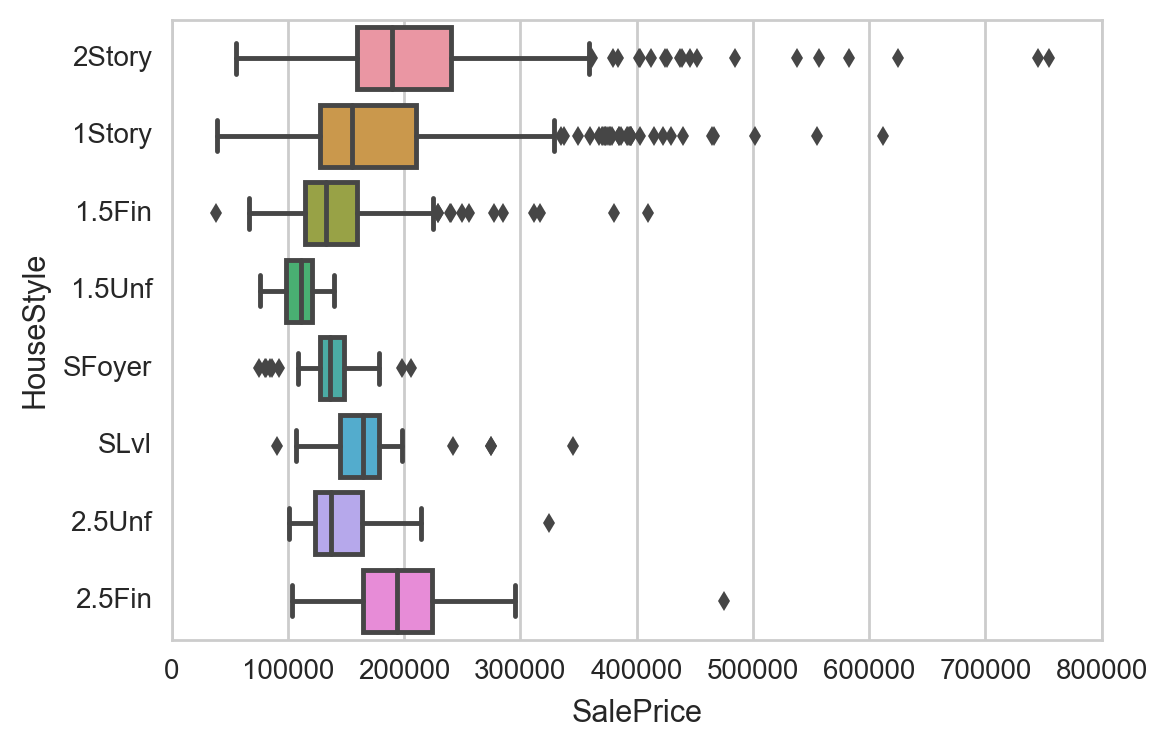

In [29]:
sns.boxplot(x=Res_houses.SalePrice, y= Res_houses.HouseStyle) #2+ story units (finished) seem to do pretty well,
# but in general the housing style does not really impact price as much as I might have thought.

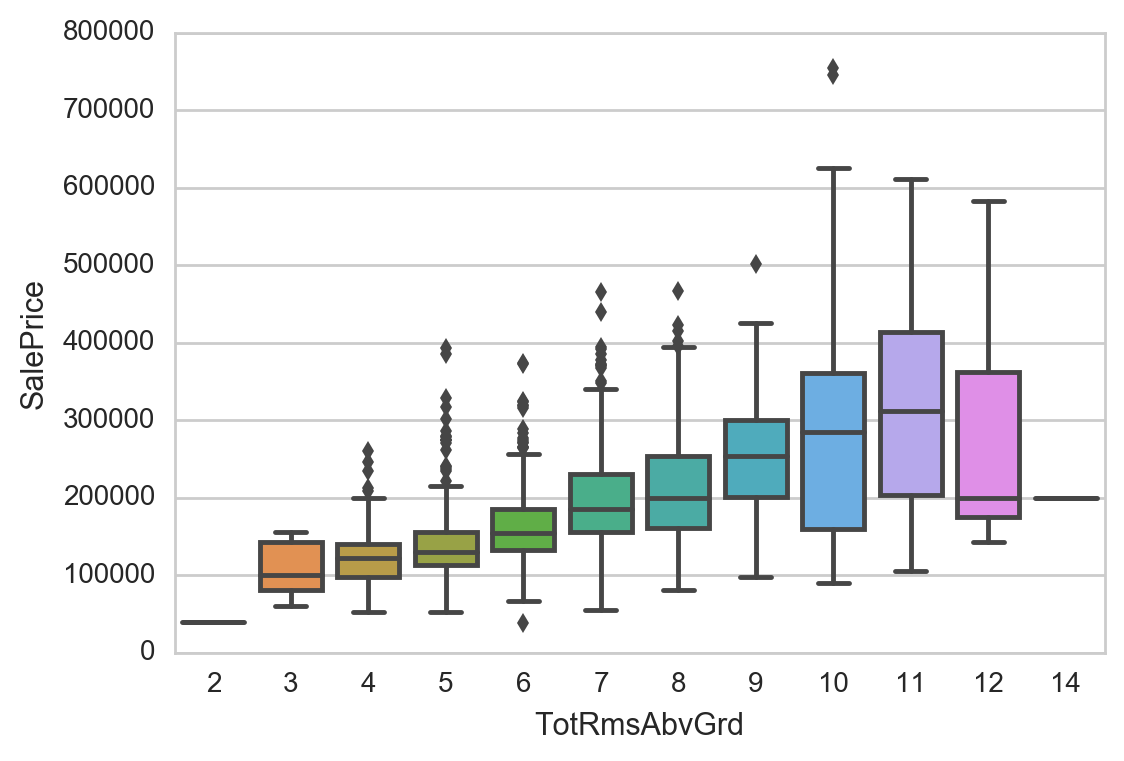

In [30]:
sns.boxplot(x=Res_houses.TotRmsAbvGrd, y= Res_houses.SalePrice) #Although I expected prices to climb with the total
# rooms above ground, I was surprised that the difference amongst medians from 4-8 all ranged about within the $100k-200k
# band. But the sale price jumped substantially on the 9th room , and stayed high through 11. The other surprise
# was how 12 had such a wide distribution.

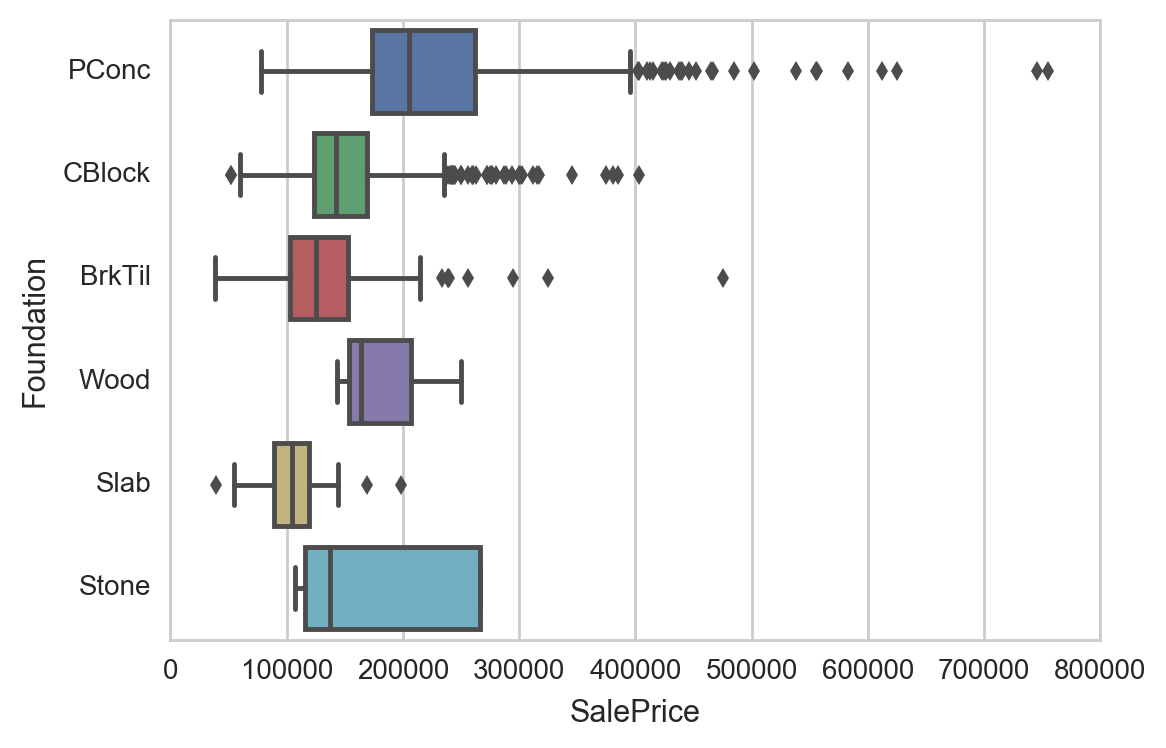

In [31]:
sns.boxplot(x=Res_houses.SalePrice, y= Res_houses.Foundation) #Note that Stone and Wood had only 3 observations each.
# poured concrete and cinder block both had b/w 600-650 observations, but there is a clear difference in the medians
# of the two. For instance, Poured Concrete's median value is much higher than even cinder block's 75% mark.

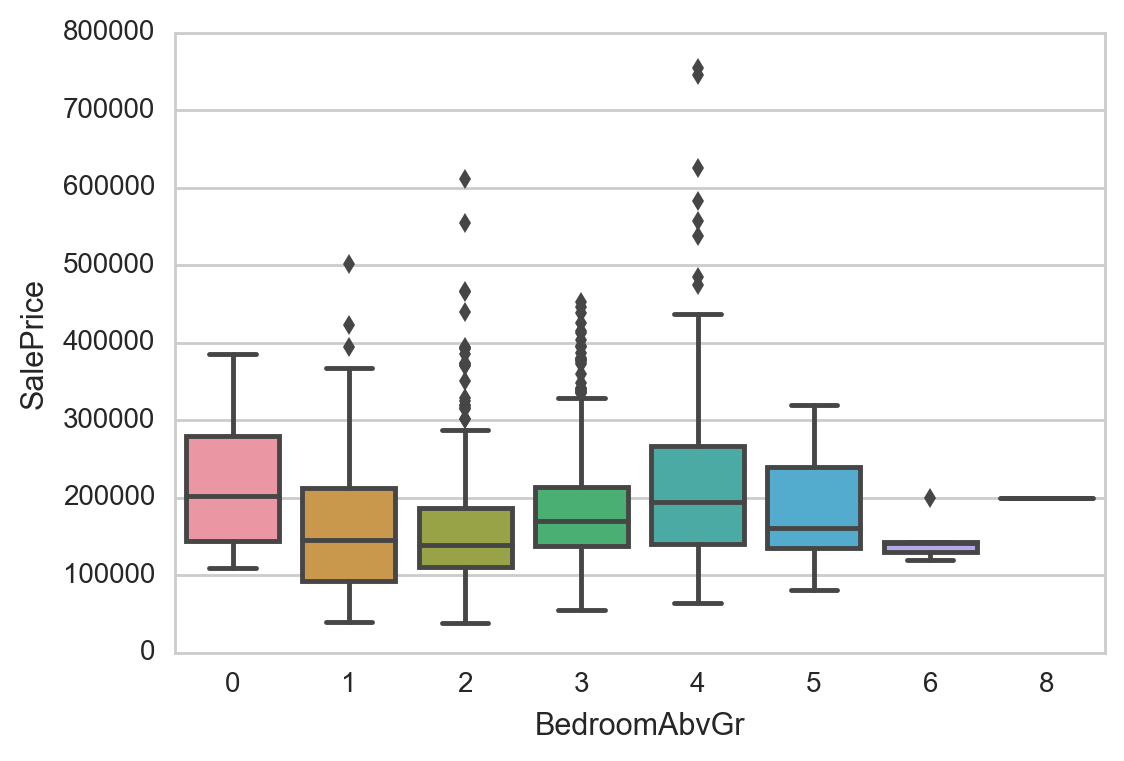

In [32]:
sns.boxplot(x=Res_houses.BedroomAbvGr, y= Res_houses.SalePrice) #3 above-ground bedrooms is by far the most common
# category, followed by 2(with a noticably lower median value) and 4 (with a noticably higher median value). But the
# fact that the difference in median sales prices across all these categories is b/w $100k-$200k was fairly surprising,
# as this indicates only nominal price differences attributed to above ground bedrooms. Prior to looking at this data,
# I had assumed this would be one of the strongest features to affect sales price.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7. Univariate regression predicting price with statsmodels

---

### 7.1 Build a linear regression with statsmodels predicting sales price from total living area sq ft.

Print the results of the regression.


In [33]:
from sklearn import datasets, linear_model
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm

In [34]:
# Res_houses.columns.sort_values(ascending=False).unique()

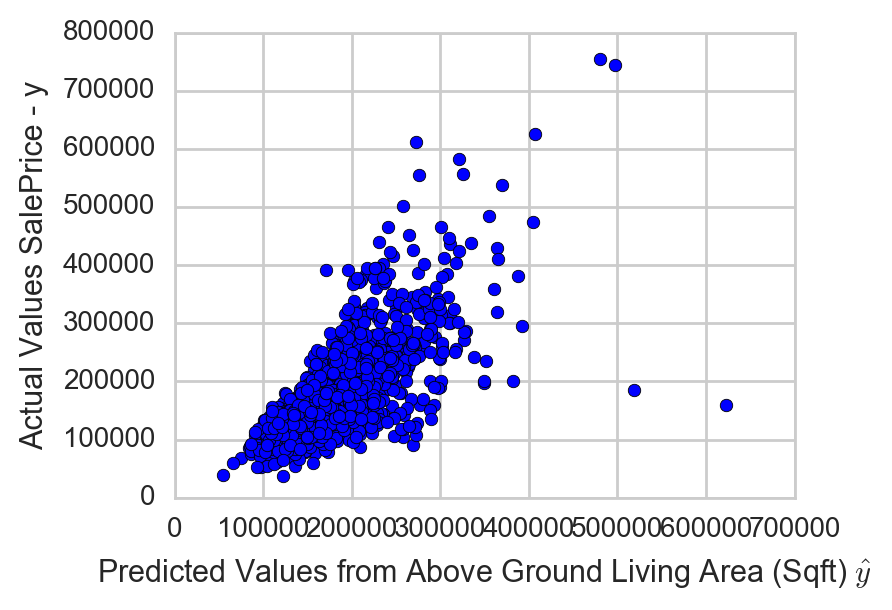

In [35]:
X = Res_houses.GrLivArea
y = Res_houses.SalePrice
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

plt.figure(figsize=(4,3))
plt.scatter(predictions, y)
# plt.scatter(X, y, color='darkred', linewidth=2)
plt.xlabel("Predicted Values from Above Ground Living Area (Sqft) $\hat{y}$")
plt.ylabel("Actual Values SalePrice - y")
plt.show()

In [36]:
model.summary()
# model.summary2()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1461.
Date:                Mon, 05 Dec 2016   Prob (F-statistic):          1.38e-221
Time:                        07:37:03   Log-Likelihood:                -17906.
No. Observations:                1450   AIC:                         3.582e+04
Df Residuals:                    1448   BIC:                         3.583e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        1.95e+04   4489.318      4.344      0.000      1.07e+04  2.83e+04
GrLivArea    106.8430      2.795     38.220      0.000       101.359   112.327
==============================================================================
Omnibus:                      264.844   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3531.303
Skew:                           0.426   Prob(JB):                         0.00
Kurtosis:                      10.598   Cond. No.                     4.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 7.2 Explain the regression results

What do each of these things represent/mean?

1. The intercept coefficient.
2. The coefficient on GrLivArea.
3. The R-squared value.
4. The p-value for coefficients (P>|t|)

In [37]:
#1) I added a constant just so my summary would visually show the fact that there is no intercept coefficient. This
# makes sense because the expected mean value of SalePrice ought to be 0 when the GrLivArea is 0 (ie there is no 
# building).
#2) The coefficient tells us that for every incremental increase in GrLivArea of 1, we can expect expect a corresponding
#increase in SalePrice of ~ $106.84
#3) The R-squared value of ~ .5 indicates a positive correlation between GrLivArea and SalePrice
#4) The p-value for coefficients indicates a test of the null hypothesis that the coefficient GrLivArea = 0. Since
# it returns a figure  very close to zero, we can reject the null hypothesis in this case.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 8. Multivariate regression predicting price with sklearn

---

### 8.1 Build an sklearn linear regression predicting sale price 

Use all of your continuous measures as predictors (no categorical yet).

In [38]:
cont_houses = Res_houses[['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
            'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','PoolArea', 'MoSold','YrSold']]

In [39]:
Res_houses.columns.sort_values() #ID, MSSubClass, MSZoning, St, Alley, LotShape, LandContour,Utilties, LotConfig
# LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl,
# Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure,
# BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu,
# GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, MiscValue, 
# SaleType, SaleCondition

Index([u'1stFlrSF', u'2ndFlrSF', u'3SsnPorch', u'AgeAtSale', u'Alley',
       u'BedroomAbvGr', u'BldgType', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtFinType1', u'BsmtFinType2',
       u'BsmtFullBath', u'BsmtHalfBath', u'BsmtQual', u'BsmtUnfSF',
       u'CentralAir', u'Condition1', u'Condition2', u'Electrical',
       u'EnclosedPorch', u'ExterCond', u'ExterQual', u'Exterior1st',
       u'Exterior2nd', u'Fence', u'FireplaceQu', u'Fireplaces', u'Foundation',
       u'FullBath', u'Functional', u'GarageArea', u'GarageCars', u'GarageCond',
       u'GarageFinish', u'GarageQual', u'GarageType', u'GrLivArea',
       u'HalfBath', u'Heating', u'HeatingQC', u'HouseStyle', u'Id',
       u'KitchenAbvGr', u'KitchenQual', u'LandContour', u'LandSlope',
       u'LotArea', u'LotConfig', u'LotFrontage', u'LotShape', u'LowQualFinSF',
       u'MSSubClass', u'MSZoning', u'MasVnrArea', u'MasVnrType',
       u'MiscFeature', u'MiscVal', u'MoSold', u'Neighborhood', u'OpenPorchSF',

In [40]:
print X.shape, y.shape

(1450, 2) (1450,)


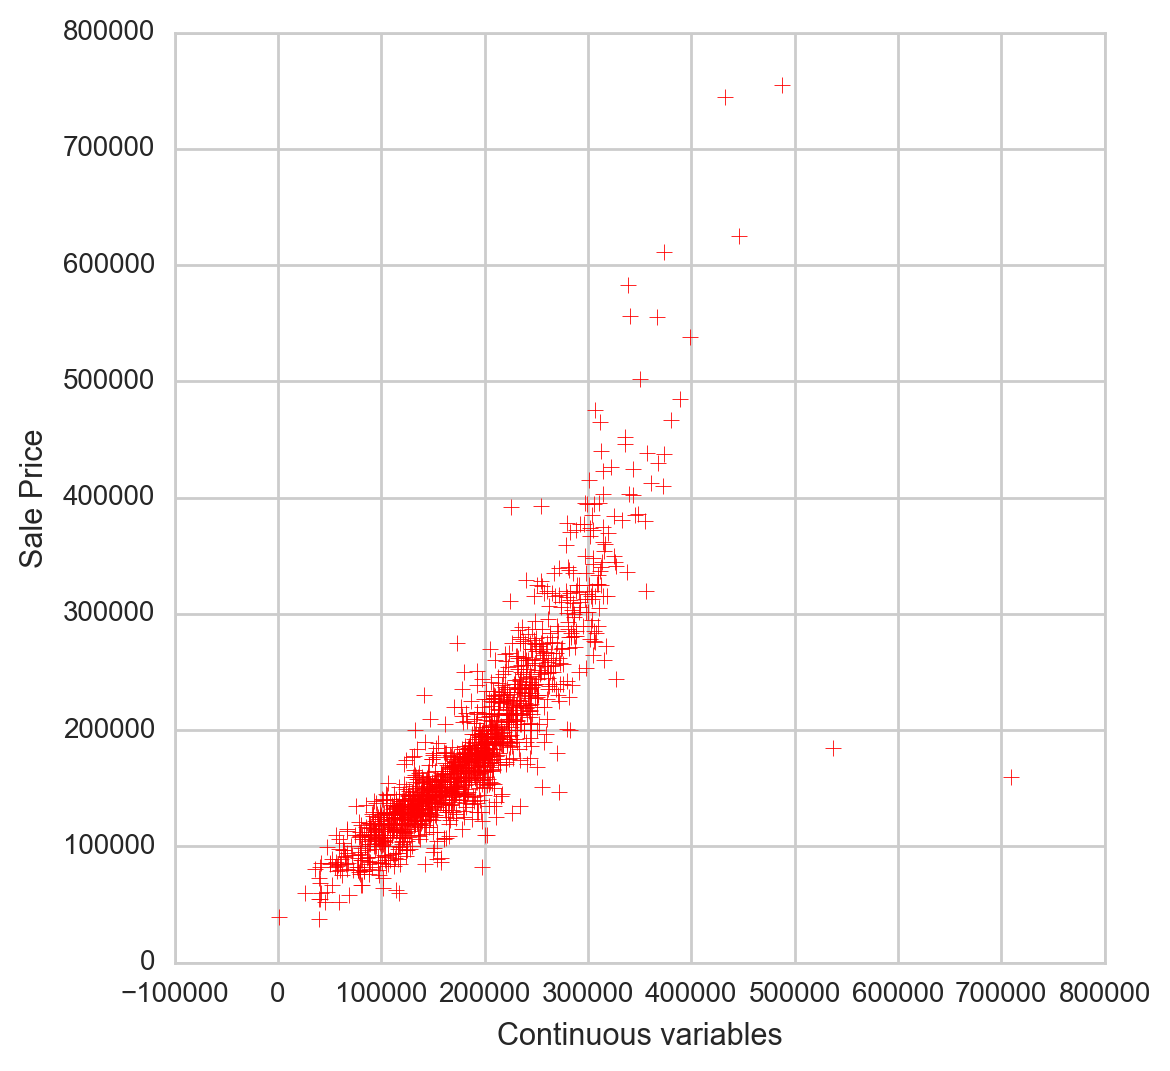

In [41]:
X = cont_houses
y = Res_houses[['SalePrice']]

lm = linear_model.LinearRegression()
model = lm.fit(X, y)
predictions = model.predict(X)

plt.figure(figsize=(6,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Continuous variables")
plt.ylabel("Sale Price")
plt.show()

### 8.2 Calculate the $R^2$ of your model.

In [42]:
score = model.score(X, y)
print "R^2:", score

R^2: 0.756347068286


### 8.3 Plot the residuals against the true values.

In [43]:
my_residuals = Res_houses[['SalePrice']] - predictions

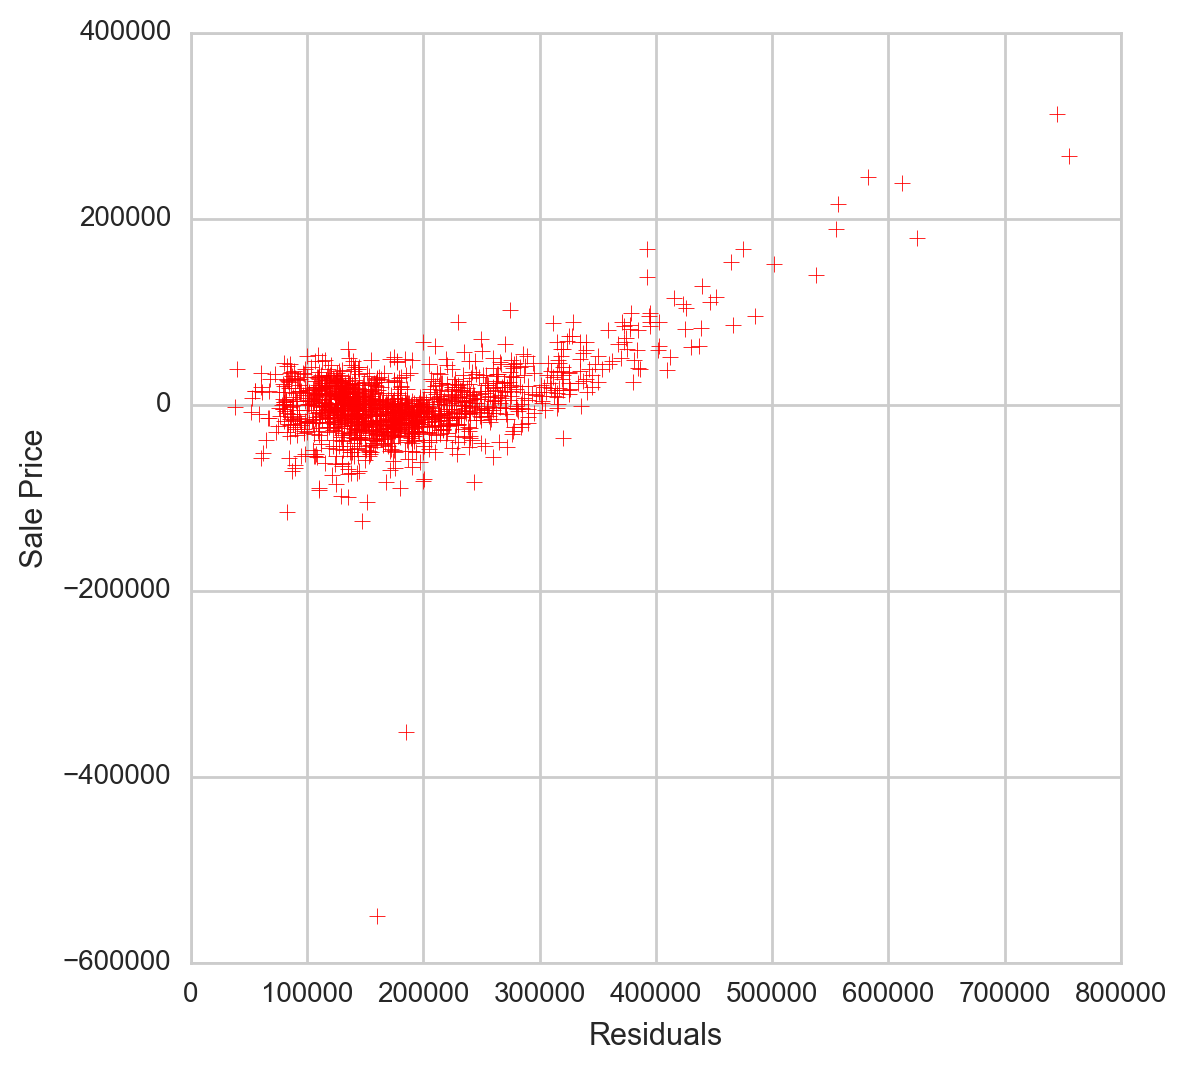

In [44]:
my_residuals
y = Res_houses[['SalePrice']]

plt.figure(figsize=(6,6))
plt.scatter(y, my_residuals, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Residuals")
plt.ylabel("Sale Price")
plt.show()

### 8.4 Plot a histogram of the residuals.

In [45]:
# sns.plt.hist(my_residuals)
# plt.show()

### 8.5 Make a plot to show the strength of the different coefficients.

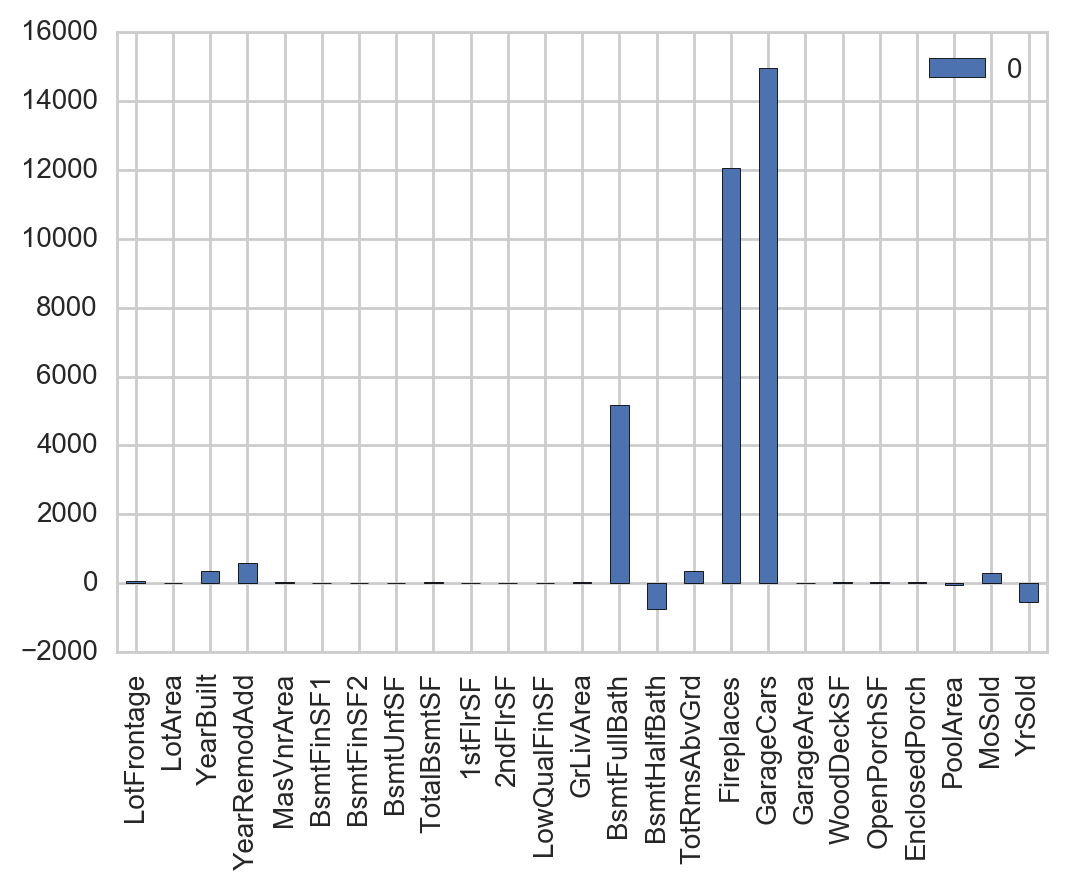

In [46]:
coef_df = pd.DataFrame(model.coef_).T
coef_df.index = X.columns
coef_df.plot(kind='bar')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 9. Create a predictor matrix using all viable predictors available to you

---

You will need to dummy code the categorical variables. This is done most easily using patsy by constructing a formula string to make the matrix, but can be done with sklearn functions or manually as well. 

Recall that the `C(variable)` syntax in patsy formulas will take the column named `'variable'` and make it into dummy coded columns. You may also need to rename columns, patsy has trouble with column names that start with numbers.

Lastly, remember that you may need to convert your target `y` from a matrix to a vector (patsy outputs it as 2D rather than 1D, which skearn may have trouble with.)

In [47]:
import patsy

In [48]:
dummy_cat = Res_houses[['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                        'LotConfig','LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                        'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                        'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                        'KitchenQual','Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'SaleType',
                        'SaleCondition','LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                        'GrLivArea','BsmtFullBath','BsmtHalfBath', 'TotRmsAbvGrd','Fireplaces','GarageCars',
                        'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','PoolArea', 'MoSold','YrSold']]

In [49]:
dummy_cat = pd.get_dummies(dummy_cat)

In [50]:
dummy_cat.head()

,MSSubClass,OverallQual,OverallCond,MiscVal,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,7,5,0,65.0,8450,2003,2003,196.0,706,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,6,8,0,80.0,9600,1976,1976,0.0,978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,7,5,0,68.0,11250,2001,2002,162.0,486,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,7,5,0,60.0,9550,1915,1970,0.0,216,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,8,5,0,84.0,14260,2000,2000,350.0,655,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
dummy_cat_formula = 'SalePrice ~ MSSubClass + MSZoning + Street + Alley + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + OverallQual + OverallCond + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + MasVnrType + ExterQual + ExterCond + Foundation + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinType2 + Heating + HeatingQC + CentralAir + Electrical + KitchenQual + Functional + FireplaceQu + GarageType + GarageFinish + GarageQual + GarageCond + PavedDrive + PoolQC + Fence + MiscFeature + MiscVal + SaleType + SaleCondition\
+ LotFrontage + LotArea + YearBuilt + YearRemodAdd + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + \
TotalBsmtSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + TotRmsAbvGrd\
+ Fireplaces + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + PoolArea + MoSold +YrSold'

In [52]:
y, X = patsy.dmatrices(dummy_cat_formula, data=Res_houses, return_type="dataframe")

In [53]:
X.head()

,Intercept,MSZoning[T.RH],MSZoning[T.RL],MSZoning[T.RM],Street[T.Pave],Alley[T.None],Alley[T.Pave],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,MoSold,YrSold
0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,8.0,0.0,2.0,548.0,0.0,61.0,0.0,0.0,2.0,2008.0
1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,6.0,1.0,2.0,460.0,298.0,0.0,0.0,0.0,5.0,2007.0
2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,6.0,1.0,2.0,608.0,0.0,42.0,0.0,0.0,9.0,2008.0
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,7.0,1.0,3.0,642.0,0.0,35.0,272.0,0.0,2.0,2006.0
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,9.0,1.0,3.0,836.0,192.0,84.0,0.0,0.0,12.0,2008.0


### 9.2 Fit a linear regression using all of the predictors and score it.

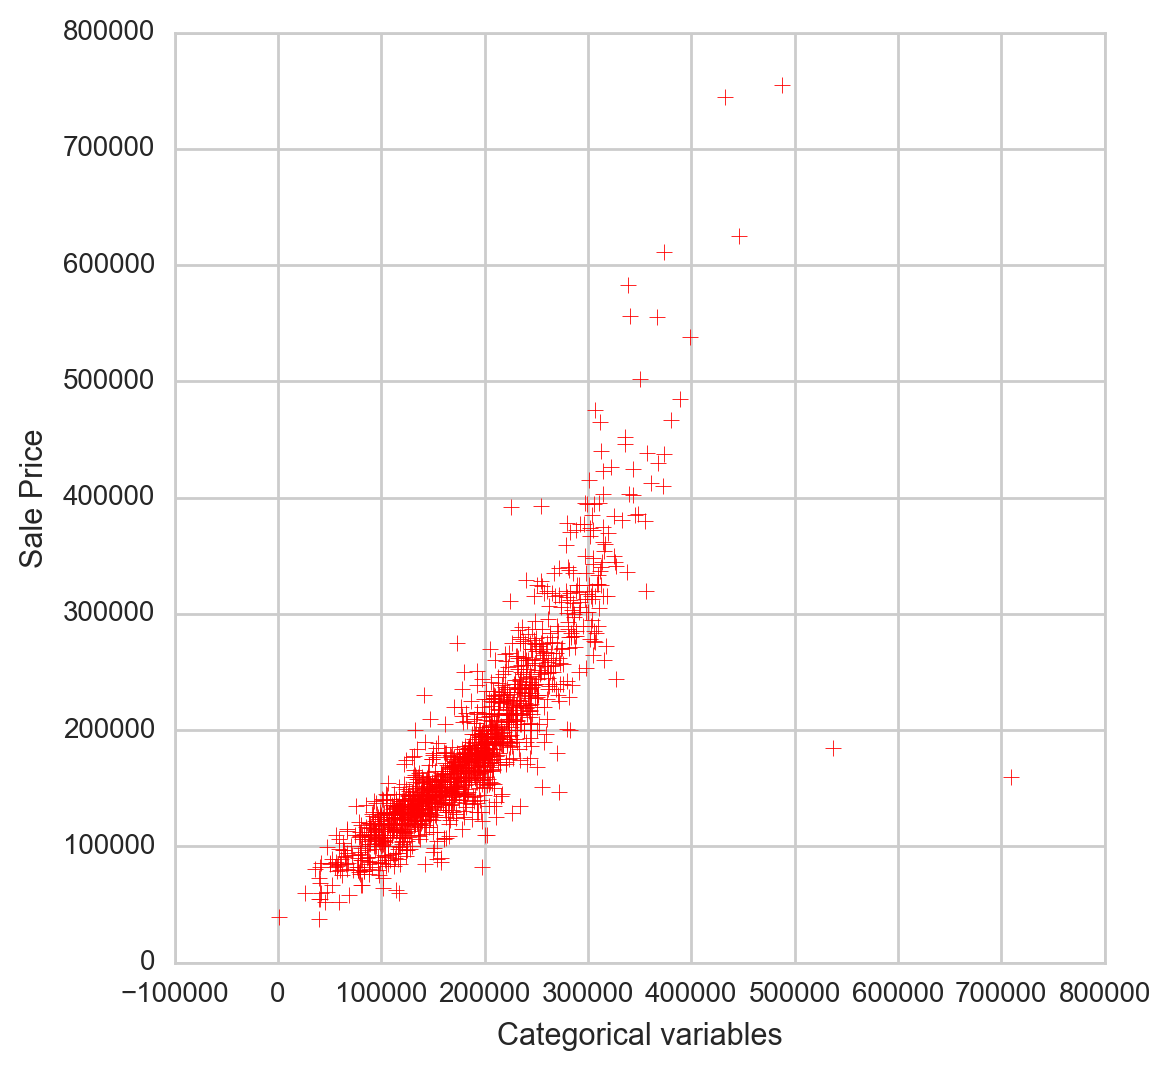

0.931313291491


In [54]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
score = model.score(X, y)

plt.figure(figsize=(6,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Categorical variables")
plt.ylabel("Sale Price")
plt.show()
print score

### 9.3 Explain why this model and associated $R^2$ score may not be as "good" as they seem.

In [55]:
# The model is severely overfitting because we have so many variables, that model is overemphasizing
# the trends that support relative linearity.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 10. Cross-validate the model

---

Use 20 folds and calculate the average $R^2$ of your model that has all of the predictors in it.

In [56]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

Mean of Cross-validated scores: 0.415582550221
Cross-Predicted Accuracy: 0.524124253573


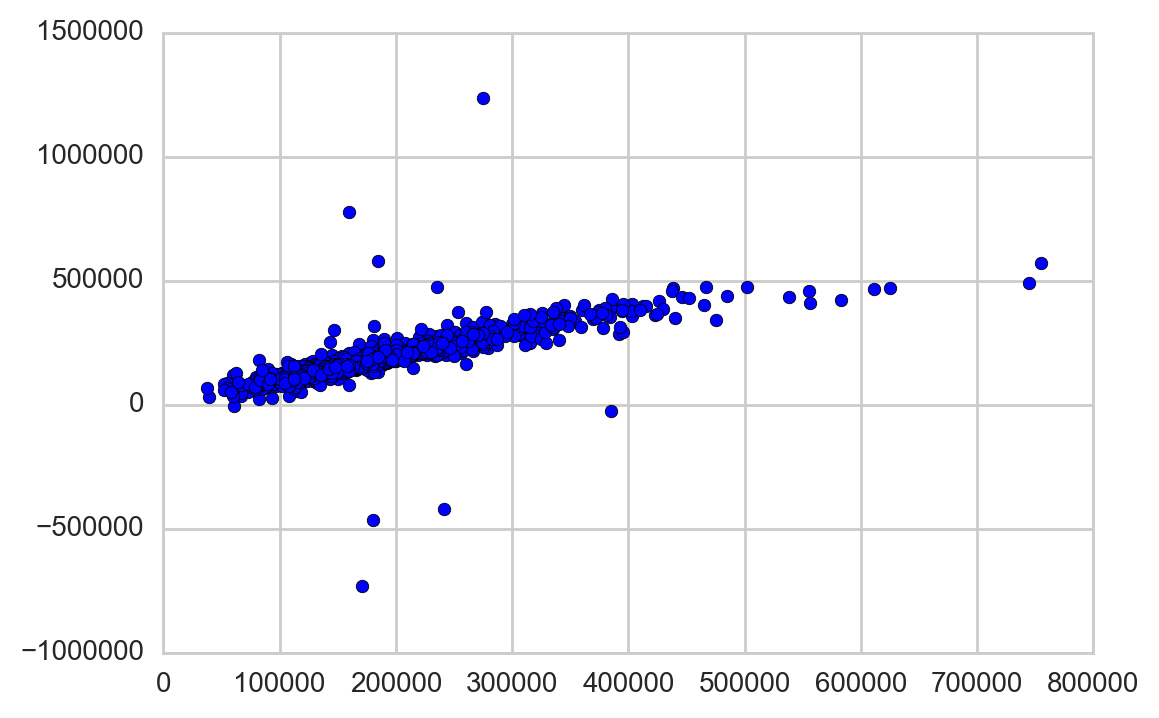

In [57]:
# Perform 20-fold cross validation
scores = cross_val_score(model, X, y, cv=20)
print "Mean of Cross-validated scores:", np.mean(scores)

#Extra goodies:
# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=20)
plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)

print "Cross-Predicted Accuracy:", accuracy

### 10.2 What does the cross-validated average $R^2$ tell you?

In [58]:
#My cross-validated scores average out to be less than half the purported score of my previous model.
#This score tends to mean that our model explains about half of the variability of SalePrices,
# though with context, we are actually more concisely showing that the the model is at best much weaker than 
# previously thought (down from about .9 to about .4)

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 10.3 When can you have a negative $R^2$ score? Explain what it means.


In [59]:
#A negative R2 means that you're predicted values are farther from the actual mean than the
#predicted values you would get from the naive mean for your data. In other words,
# a naive mean as your model would have performed better, in terms of predicting more closely the actual values
# than did your regression.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 11. Construct a Lasso regression and find the optimal regularization strength

---

Now you'll fit a Lasso regression using again the full predictor matrix. 

### 11.1 Using either `LassoCV` or `GridSearchCV` with `Lasso`, find the optimal regularization strength.

You are finding the best `alpha` to use with this data. For `LassoCV` you can use the `n_alphas` parameter to specify how many possible alphas you want the model to search over. With `GridSearchCV` you will have to give it a vector of the alphas you want to try.

Note that in both cases you will need to specify the number of cross-validation folds `cv`. 10 is generally a good number of folds. 

**Remember that you must standardize your predictor matrix when using regularization!**

In [87]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(X)
y = Res_houses.SalePrice.values

### 11.2 Construct a `Lasso` model with the optimal `alpha` and cross-validate the $R^2$.

In [92]:
optimal_lasso = LassoCV(n_alphas=100, cv=10, verbose=1)
optimal_lasso.fit(Xn, y)

print optimal_lasso.alpha_

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1170.22072698


.[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 11.3 Explain the effect of the Lasso regularization and why it can be useful.

In [ ]:
# Lasso regularization is a method to regularize data that is particularly affected by multicollinearity, having 
# many many variables/features. Lasso regularization works to de-emphasize the aforementioned variables
# where there effects are less pronounced, or basically less relevant for the regularization. Often,
# such variables are thought of as 'noise,' because in the regression model, they overweight
# less important variables. The remaining model leaves you with fewer variables affecting your model,
# enabling less variance to be present in the model (though in exchange for higher bias).

### 11.4 Print out the variables with non-zero Lasso coefficients (with the coefficient).

How many variables remain? 

Tell a (brief) story about what is important for estimating price based on the variables and their coefficients. Just pick out the things most interesting to you.

In [ ]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

In [79]:
lasso.fit(Xn, y)

Lasso(alpha=1170.2207269816638, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [83]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(10)

#I didn't quite figure out how to drop the coefficients that were zero

,abs_coef,coef,variable
239,25371.274037,25371.274037,GrLivArea
226,17006.411522,17006.411522,OverallQual
35,8606.261339,8606.261339,Neighborhood[T.NridgHt]
244,6969.015141,6969.015141,GarageCars
225,6299.774990,-6299.774990,MSSubClass
231,6190.453393,6190.453393,YearBuilt
34,6111.849483,6111.849483,Neighborhood[T.NoRidge]
202,5936.060962,-5936.060962,PoolQC[T.Gd]
41,5251.898133,5251.898133,Neighborhood[T.StoneBr]
55,5145.674885,-5145.674885,Condition2[T.PosN]


In [ ]:
#From above, we can see that the above ground living area in sqft is a strong determining factor on price,
# as well as the overall condition of the property. This makes sense given that in the housing market,
# prices are often dictated by square footage.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 12. Construct a Ridge regression and find the optimal regularization strength

---

### 12.1 Create a predictor matrix of only variables related to sq. ft.

**Remember that you must standardize your predictor matrix before using Ridge regularization.**

In [ ]:
# Given that I did not remove the zon-zero variables in the previous problem, I am advancing with the predictors I have.

### 12.2 Plot a correlation matrix of your predictors. Why might Ridge be useful here?

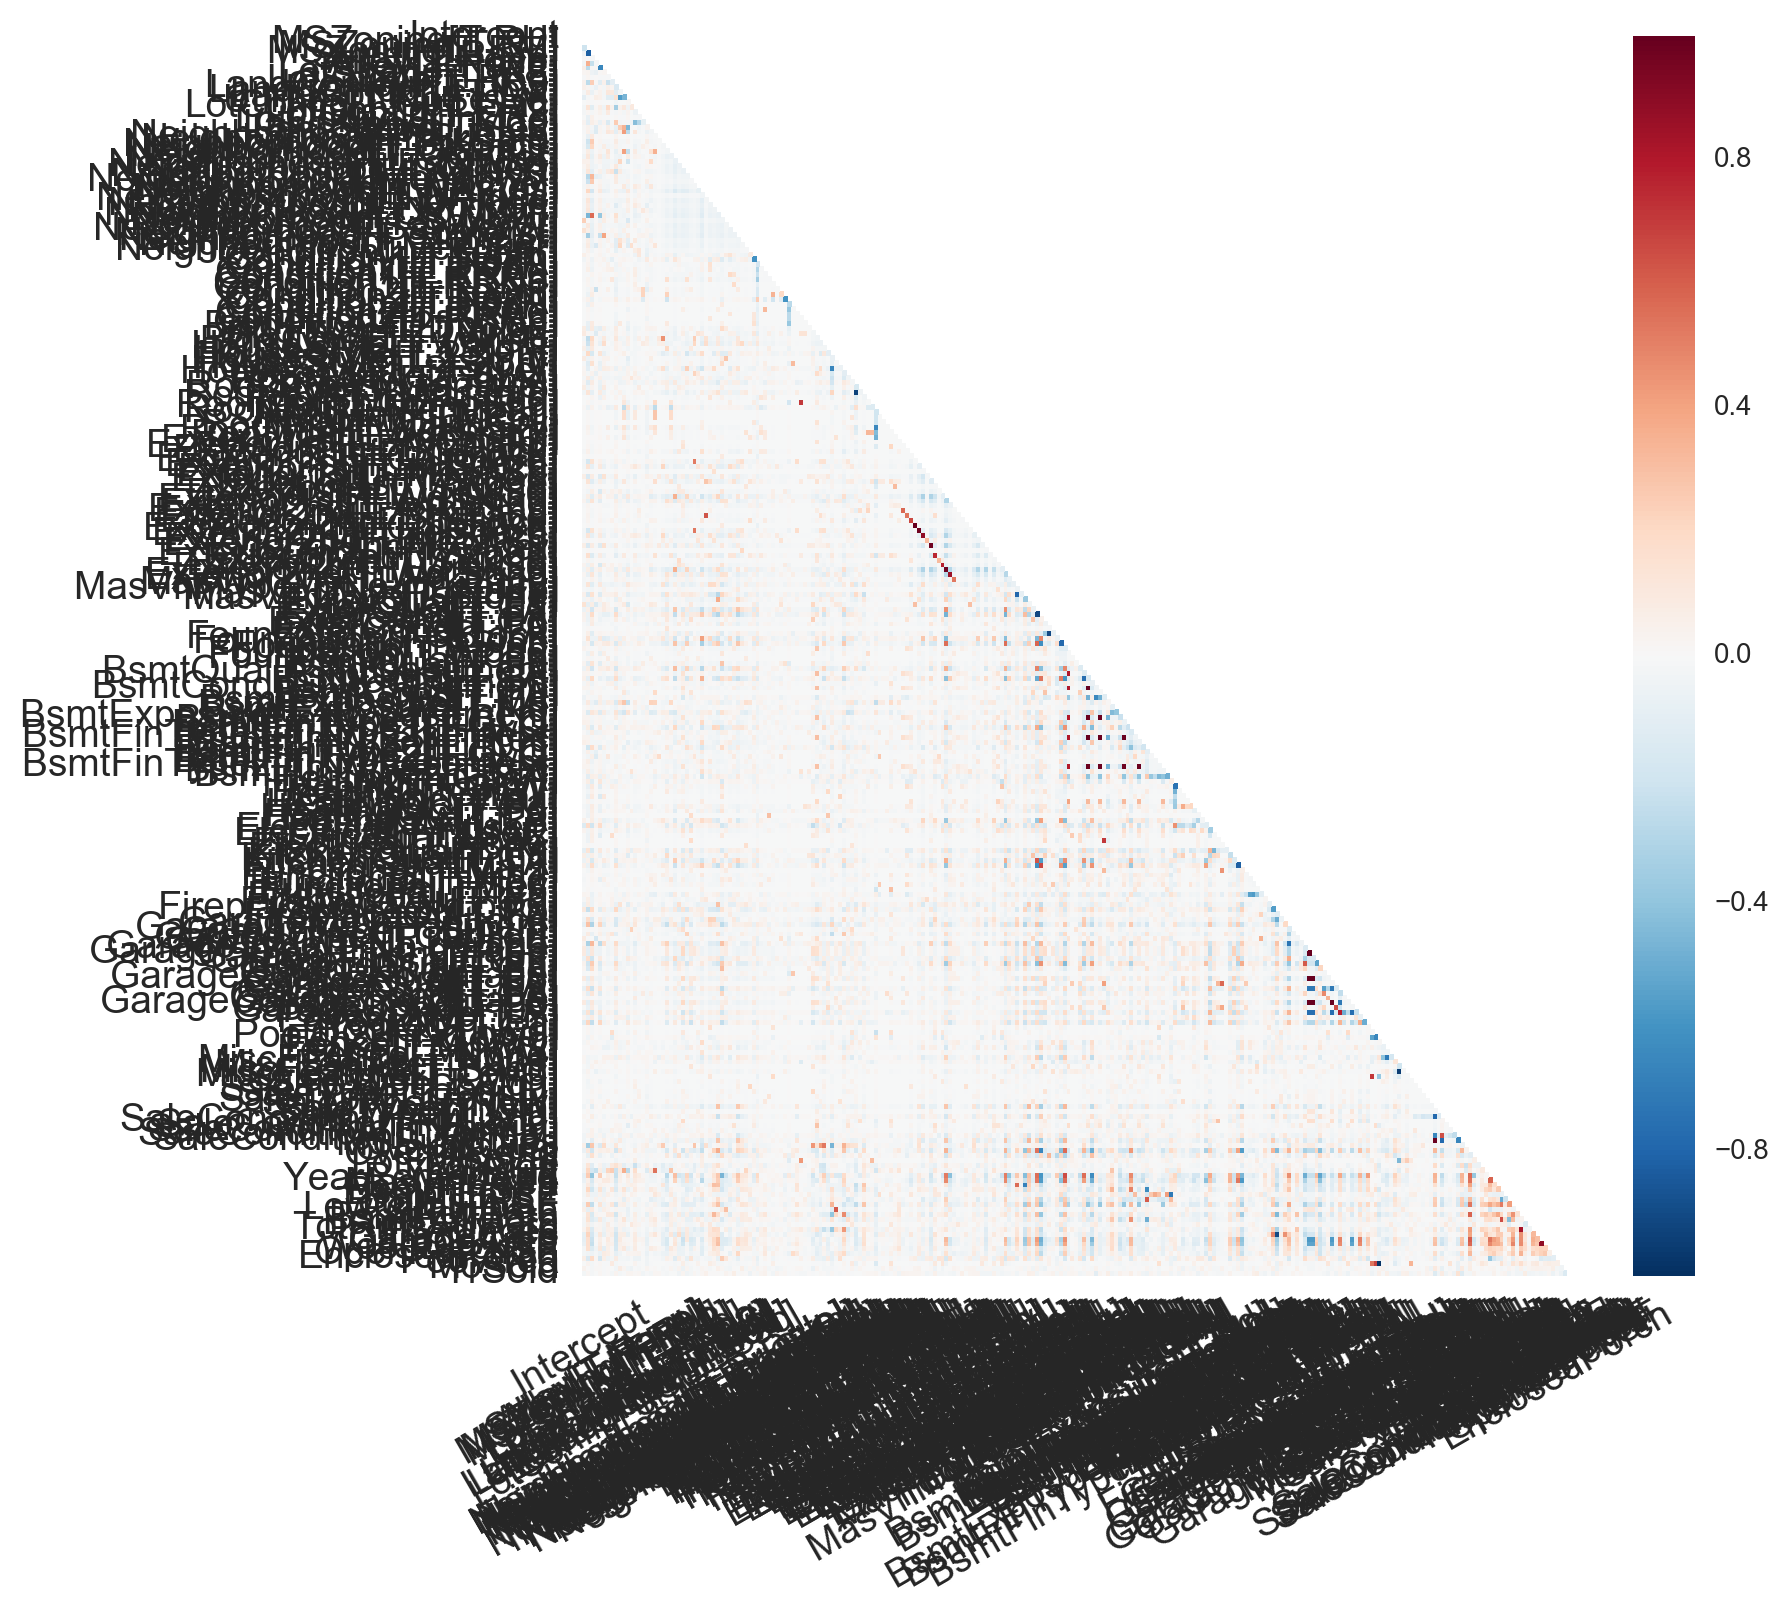

In [85]:
correlation_heat_map(X) #lol, well there's sort of a lot of variables, as can be visualized. So Ridge is useful to
# handle the shear number of features (where Lasso helps us cope with multi-collinearity).

### 12.3 Find the optimal Ridge `alpha` using either `RidgeCV` or a combination of `GridSearchCV` and `Ridge`.



In [90]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.91783273  0.89208075  0.90484867  0.78473301  0.86106211  0.82693375
  0.86697472  0.8589527   0.5755216   0.85725327]
0.834619330174


In [93]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, y)

RidgeCV(alphas=array([  1.00000e+00,   1.05956e+00, ...,   9.43788e+04,   1.00000e+05]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

### 12.4 Compare the cross-validated $R^2$ score for a standard Linear Regression and your Ridge regression

In [97]:
ridge.fit(Xn, y)

Ridge(alpha=488.02515836544336, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [100]:
ridge_scores = cross_val_score(ridge, Xn, y, cv =10)
print np.mean(ridge_scores) #== .834619
# compared to about .5 for the linear

0.834619330174


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 13. Explain the difference between Ridge and Lasso regularization

---

- When are good scenarios to use each? What problems do they address?
- Why do they have the effects they do on coefficients?
- What is their effect on bias and variance?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 14. Gridsearch an optimal `ElasticNet` regression.

---

On the full predictor matrix, search for the optimal hyperparameters for an Elastic Net regression. Remember that the Elastic net is a mixture of the Ridge and Lasso, and has both an `alpha` parameter to regularize as well as an `l1_ratio`, which is the balance of Lasso vs. Ridge.

How does the ElasticNet compare to the Lasso on the dataset? What does the `l1_ratio` tell you about the balance of Ridge vs. Lasso in your model?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 15. Further fine-tune the model to predict price

---

Your goal is to create the model with the best predictive power.

You can use as much feature engineering and transformation of variables that you want, but please limit yourself to using the regression models we have covered in class thus far. When we cover models like Random Forests and Gradient Boosted Trees we will return to this dataset and see how they compare to the regression models.

For those that tackle this problem, you will have a chance to show what you did and compare to what your other classmates came up with during class (if you want). **Feel free to collaborate with your classmates on improving the model!**